# Market Forecasting with Machine Learning and Technical Indicators

This notebook evaluates multiple machine learning models and a range of market indicators to determine the most effective combination for market prediction.


### Testing Classification with logistic regression and Random Forest

In [ ]:
import yfinance as yf   # Importing yfinance to download stock market data
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import os
import matplotlib.pyplot as plt             #pip install matplotlib -- Install matplotlib if not installed
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    accuracy_score,
    roc_auc_score, # Area under the ROC curve (classification performance)
)
import joblib
# Technical analysis indicators from the 'ta' library
from ta.momentum import RSIIndicator        # Relative Strength Index for momentum analysis
from ta.trend import MACD                   # Moving Average Convergence Divergence for trend following
from ta.volatility import BollingerBands    # Bollinger Bands for measuring volatility
from datetime import datetime, timezone

In [ ]:
# 1. DATA LOADING & CLEANING

if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0,parse_dates=True)
else:
    sp500 = yf.Ticker("^GSPC").history(period="max")
    sp500.to_csv("sp500.csv")

# Filter the S&P 500 data to include only records from January 1, 1990 onwards
# The datetime is set with UTC timezone to match the format of the index
sp500 = sp500.loc[datetime(1990, 1, 1, tzinfo=timezone.utc):].copy()

# Drop unused columns
sp500.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)

In [ ]:
# 2. LABEL CREATION

# Create a new column 'Tomorrow' that contains the next day's closing price
sp500["Tomorrow"] = sp500["Close"].shift(-1)
# Create a binary 'Target' column: 1 if the next day's close is higher than today's, else 0
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [ ]:
# 3. FEATURE ENGINEERING

# Define different rolling time windows (in days) to capture short-, mid-, and long-term trends
horizons = [2, 5, 60, 250, 1000]

for horizon in horizons:
    # Feature 1: Close_Ratio - Ratio of current close to rolling average close over the given horizon
    sp500[f"Close_Ratio_{horizon}"] = sp500["Close"] / sp500["Close"].rolling(horizon).mean()
    
    # Feature 2: Trend - Sum of past positive movements (targets) over the horizon
    sp500[f"Trend_{horizon}"] = sp500["Target"].shift(1).rolling(horizon).sum()

# RSI: Relative Strength Index to measure momentum (typically between 0 and 100)
sp500["RSI"] = RSIIndicator(close=sp500["Close"]).rsi()

# MACD: Moving Average Convergence Divergence for identifying trend direction and momentum
macd = MACD(close=sp500["Close"])
sp500["MACD"] = macd.macd()                        # MACD line
sp500["MACD_signal"] = macd.macd_signal()          # Signal line
sp500["MACD_diff"] = macd.macd_diff()              # MACD histogram = MACD - Signal

# Bollinger Bands: Measure price volatility around a moving average
bollinger = BollingerBands(close=sp500["Close"])
sp500["bollinger_h"] = bollinger.bollinger_hband() # Upper band
sp500["bollinger_l"] = bollinger.bollinger_lband() # Lower band
sp500["bollinger_m"] = bollinger.bollinger_mavg()  # Middle band (moving average)
sp500["bollinger_pct"] = ((sp500["Close"] - sp500["bollinger_l"]) / (sp500["bollinger_h"] - sp500["bollinger_l"]))  # Position of close within the bands (0 = lower, 1 = upper)

# Drop rows that contain NaN values 
sp500.dropna(inplace=True)

# Define final list of predictor features for model training
predictors = [
    "Close", "Volume", "Open", "High", "Low",
    "RSI", "MACD_diff", "bollinger_pct"
] + [f"Close_Ratio_{h}" for h in horizons] + [f"Trend_{h}" for h in horizons]


In [17]:
print(sp500.head())

                                 Open        High         Low       Close  \
Date                                                                        
1993-12-14 00:00:00-05:00  465.730011  466.119995  462.459991  463.059998   
1993-12-15 00:00:00-05:00  463.059998  463.690002  461.839996  461.839996   
1993-12-16 00:00:00-05:00  461.859985  463.980011  461.859985  463.339996   
1993-12-17 00:00:00-05:00  463.339996  466.380005  463.339996  466.380005   
1993-12-20 00:00:00-05:00  466.380005  466.899994  465.529999  465.850006   

                              Volume    Tomorrow  Target  Close_Ratio_2  \
Date                                                                      
1993-12-14 00:00:00-05:00  275050000  461.839996       0       0.997157   
1993-12-15 00:00:00-05:00  331770000  463.339996       1       0.998681   
1993-12-16 00:00:00-05:00  284620000  466.380005       1       1.001621   
1993-12-17 00:00:00-05:00  363750000  465.850006       0       1.003270   
1993-12-20

In [ ]:
# 4. BACKTESTING FUNCTIONS

def predict(train, test, predictors, model, threshold=0.5):
    #Train the model on the training set and predict on the test set.
    #threshold (float): Classification threshold (default 0.5)
    model.fit(train[predictors], train["Target"])
    probs = model.predict_proba(test[predictors])[:, 1]
    preds = (probs >= threshold).astype(int)
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, threshold=0.5, start=2500, step=250):
    #Perform walk-forward backtesting to simulate real-world trading.
    all_predictions = []
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i + step)].copy()
        predictions = predict(train, test, predictors, model, threshold)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)




📊 Evaluation for Random Forest
Precision: 0.5578666666666666
Recall: 0.3543360433604336
F1 Score: 0.43339548373731096
Accuracy: 0.49417421860551136
ROC AUC: 0.5083289178105631


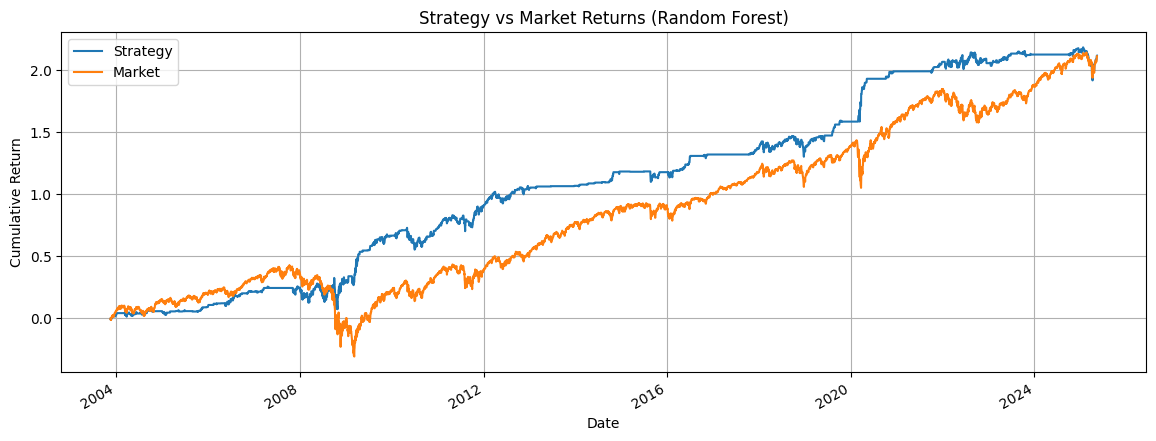


📊 Evaluation for Logistic Regression
Precision: 0.5397649631046734
Recall: 0.6690379403794038
F1 Score: 0.5974890334291333
Accuracy: 0.5078601812465323
ROC AUC: 0.4915454467681133


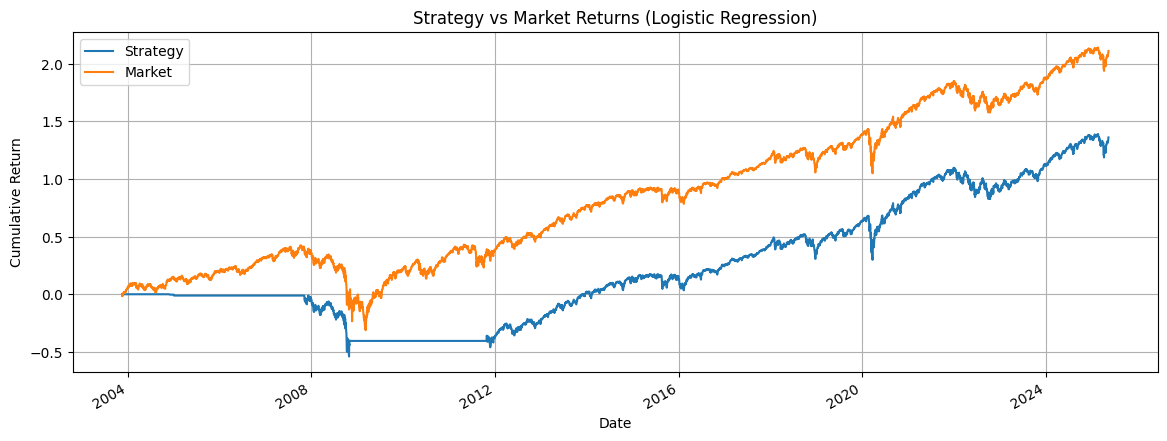

✅ Models saved.


In [ ]:
# 5. Model Evaluation Function

def evaluate_model(predictions, label="Model"):
    #Print evaluation metrics and plot cumulative returns of strategy vs market.
    print(f"\n📊 Evaluation for {label}")
    print("Precision:", precision_score(predictions["Target"], predictions["Predictions"]))
    print("Recall:", recall_score(predictions["Target"], predictions["Predictions"]))
    print("F1 Score:", f1_score(predictions["Target"], predictions["Predictions"]))
    print("Accuracy:", accuracy_score(predictions["Target"], predictions["Predictions"]))
    print("ROC AUC:", roc_auc_score(predictions["Target"], predictions["Predictions"]))


    # STRATEGY
    sim = sp500.loc[predictions.index].copy()
    # Strategy return: only apply % change when prediction = 1 (buy signal)
    sim["Strategy"] = predictions["Predictions"].shift(1) * sim["Close"].pct_change()
    # Market return: daily % change in actual price
    sim["Market"] = sim["Close"].pct_change()
    # Plot cumulative returns of strategy vs market
    sim[["Strategy", "Market"]].cumsum().plot(
        figsize=(14, 5), 
        title=f"Strategy vs Market Returns ({label})"
    )
    plt.ylabel("Cumulative Return")
    plt.grid(True)
    plt.show()

#6 Run Models
# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200,          # Number of trees
    min_samples_split=50,      # Minimum samples required to split a node
    class_weight="balanced",   # Handle class imbalance
    random_state=1             # Reproducibility
)

# Backtest Random Forest on the S&P 500 data
rf_predictions = backtest(sp500, rf_model, predictors, threshold=0.5)
evaluate_model(rf_predictions, "Random Forest")

# Logistic Regression Classifier
log_model = LogisticRegression(
    max_iter=1000,             # Max iterations for convergence
    class_weight="balanced",   # Handle imbalance in Target
    solver='lbfgs'             # Optimization algorithm
)

# Backtest Logistic Regression
log_predictions = backtest(sp500, log_model, predictors, threshold=0.5)
evaluate_model(log_predictions, "Logistic Regression")



# 8. SAVE THE MODELs
joblib.dump(rf_model, "rf_market_model.pkl")
joblib.dump(log_model, "logreg_market_model.pkl")
print("✅ Models saved.")

#### Choosing some Essential Predictors instead of largest number of predictors

In [ ]:
essential_predictors = [
    "RSI", "MACD_diff", "bollinger_pct",
    "Close_Ratio_5", "Trend_5", "Close_Ratio_250", "Trend_250"
]


📊 Evaluation for Random Forest
Precision: 0.5515210991167812
Recall: 0.5711382113821138
F1 Score: 0.5611582626060909
Accuracy: 0.5122988718328093
ROC AUC: 0.5063430364446211


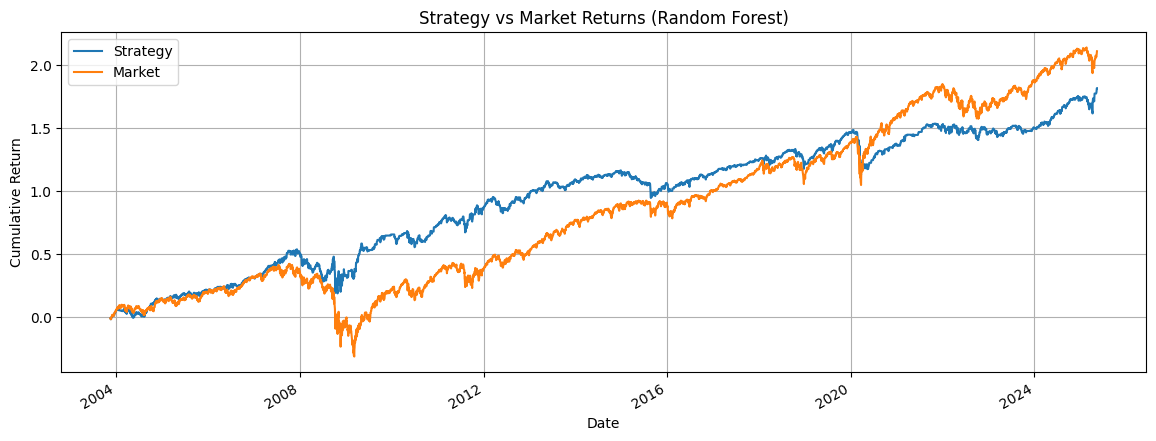


📊 Evaluation for Logistic Regression
Precision: 0.5505082592121983
Recall: 0.587059620596206
F1 Score: 0.5681967213114754
Accuracy: 0.512853708156094
ROC AUC: 0.5053424375893454


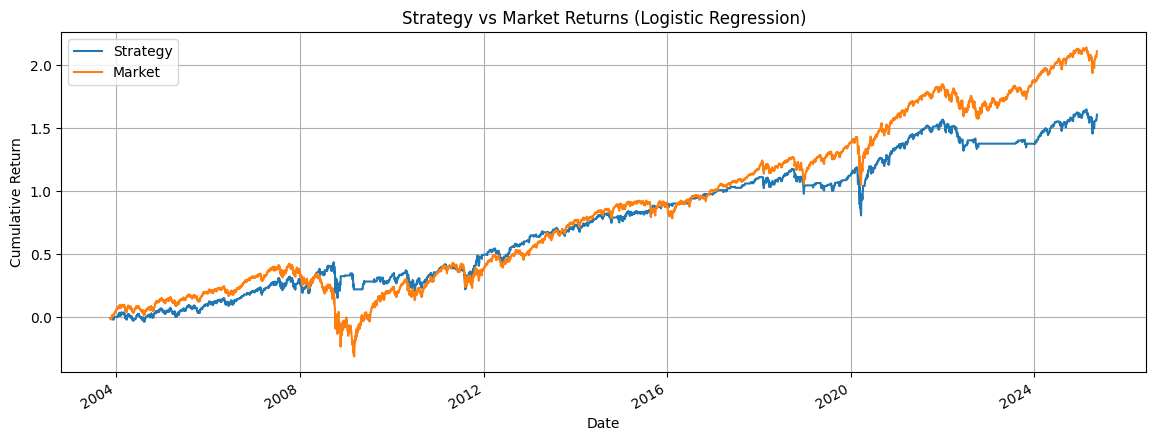

✅ Models saved.


In [ ]:
# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200,          # Number of trees
    min_samples_split=50,      # Minimum samples required to split a node
    class_weight="balanced",   # Handle class imbalance
    random_state=1             # Reproducibility
)

# Backtest Random Forest on the S&P 500 data
rf_predictions = backtest(sp500, rf_model, essential_predictors, threshold=0.5)
evaluate_model(rf_predictions, "Random Forest")

# Logistic Regression Classifier
log_model = LogisticRegression(
    max_iter=1000,             # Max iterations for convergence
    class_weight="balanced",   # Handle imbalance in Target
    solver='lbfgs'             # Optimization algorithm
)

# Backtest Logistic Regression
log_predictions = backtest(sp500, log_model, essential_predictors, threshold=0.5)
evaluate_model(log_predictions, "Logistic Regression")


# 8. SAVE THE MODELs
joblib.dump(rf_model, "rf_market_model.pkl")
joblib.dump(log_model, "logreg_market_model.pkl")
print("✅ Models saved.")

#### Scaling the Predictors

In [ ]:
from sklearn.preprocessing import StandardScaler

# Create a scaler
scaler = StandardScaler()

# Fit scaler on the whole dataset (could use only training in production)
scaled_data = sp500.copy()
scaled_data[predictors] = scaler.fit_transform(sp500[predictors])
scaled_data



📊 Evaluation for Random Forest
Precision: 0.5516339869281046
Recall: 0.5718157181571816
F1 Score: 0.5615435795076513
Accuracy: 0.5124838172739042
ROC AUC: 0.506478123844375


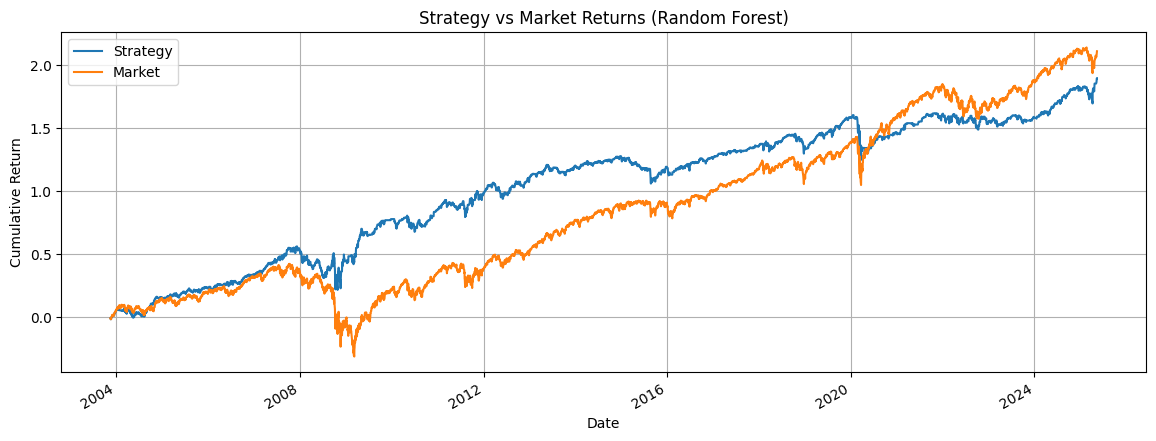


📊 Evaluation for Logistic Regression
Precision: 0.5503708281829419
Recall: 0.603319783197832
F1 Score: 0.5756302521008403
Accuracy: 0.514333271684853
ROC AUC: 0.5053258793789567


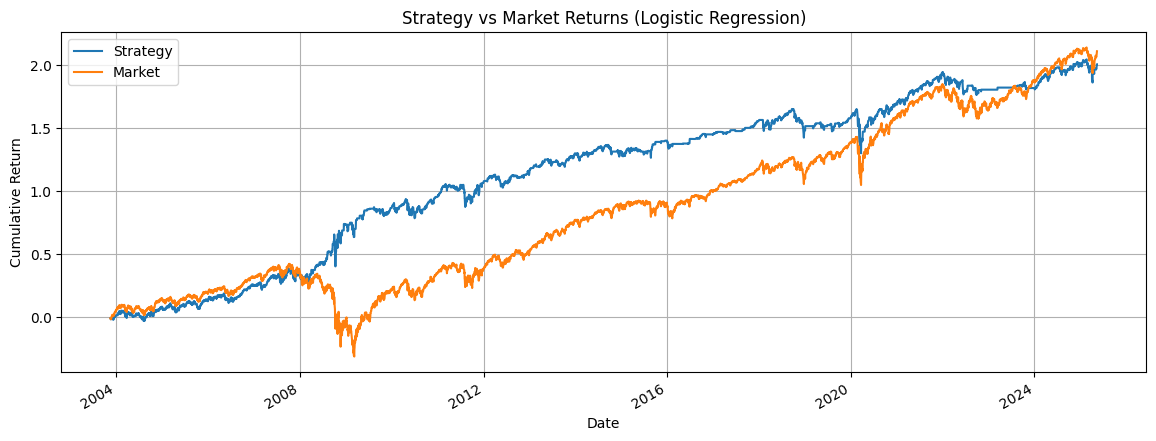

✅ Models saved.


In [26]:
# Random Forest Classifier
rf_model = RandomForestClassifier(
    n_estimators=200,          # Number of trees
    min_samples_split=50,      # Minimum samples required to split a node
    class_weight="balanced",   # Handle class imbalance
    random_state=1             # Reproducibility
)

# Backtest Random Forest on the S&P 500 data
rf_predictions = backtest(scaled_data, rf_model, essential_predictors, threshold=0.5)
evaluate_model(rf_predictions, "Random Forest")

# Logistic Regression Classifier
log_model = LogisticRegression(
    max_iter=1000,             # Max iterations for convergence
    class_weight="balanced",   # Handle imbalance in Target
    solver='lbfgs'             # Optimization algorithm
)

# Backtest Logistic Regression
log_predictions = backtest(scaled_data, log_model, essential_predictors, threshold=0.5)
evaluate_model(log_predictions, "Logistic Regression")



# 8. SAVE THE MODELs

joblib.dump(rf_model, "rf_market_model.pkl")
joblib.dump(log_model, "logreg_market_model.pkl")
print("✅ Models saved.")

### Testing Regression with Random Forest, SVR, Linear Regression

In [ ]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:

# 1. Load and Preprocess Data
sp500 = yf.Ticker("^GSPC").history(period="max")
sp500 = sp500.loc[datetime(1990, 1, 1, tzinfo=timezone.utc):].copy()
sp500.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)

In [ ]:

# 2. Add Technical Indicators
horizons = [5, 250]
for horizon in horizons:
    sp500[f"Close_Ratio_{horizon}"] = sp500["Close"] / sp500["Close"].rolling(horizon).mean()
    sp500[f"Trend_{horizon}"] = (sp500["Close"].shift(1) < sp500["Close"].shift(0)).rolling(horizon).sum()

sp500["RSI"] = RSIIndicator(close=sp500["Close"]).rsi()
macd = MACD(close=sp500["Close"])
sp500["MACD_diff"] = macd.macd_diff()
boll = BollingerBands(close=sp500["Close"])
sp500["bollinger_pct"] = (sp500["Close"] - boll.bollinger_lband()) / (boll.bollinger_hband() - boll.bollinger_lband())

sp500["Target_Close"] = sp500["Close"].shift(-1)
sp500["Target_Low"] = sp500["Low"].shift(-1)
sp500["Target_High"] = sp500["High"].shift(-1)

sp500.dropna(inplace=True)



In [41]:
sp500.head

<bound method NDFrame.head of                                   Open         High          Low        Close  \
Date                                                                            
1990-12-26 00:00:00-05:00   329.890015   331.690002   329.890015   330.850006   
1990-12-27 00:00:00-05:00   330.850006   331.040009   328.230011   328.290009   
1990-12-28 00:00:00-05:00   328.290009   328.720001   327.239990   328.720001   
1990-12-31 00:00:00-05:00   328.709991   330.230011   327.500000   330.220001   
1991-01-02 00:00:00-05:00   330.200012   330.750000   326.450012   326.450012   
...                                ...          ...          ...          ...   
2025-05-08 00:00:00-04:00  5663.600098  5720.100098  5635.379883  5663.939941   
2025-05-09 00:00:00-04:00  5679.649902  5691.689941  5644.149902  5659.910156   
2025-05-12 00:00:00-04:00  5807.200195  5845.370117  5786.080078  5844.189941   
2025-05-13 00:00:00-04:00  5854.149902  5906.640137  5845.020020  5886.549805  

In [ ]:

# 3. Setup Features and Targets

# predictors = [
#     "Close", "Volume", "Open", "High", "Low",
#     "RSI", "MACD_diff", "bollinger_pct"
# ] + [f"Close_Ratio_{h}" for h in horizons] + [f"Trend_{h}" for h in horizons]

predictors = [
    "RSI", "MACD_diff", "bollinger_pct",
    "Close_Ratio_5", "Trend_5", "Close_Ratio_250", "Trend_250"
]

#scaler = StandardScaler()
#sp500[predictors] = scaler.fit_transform(sp500[predictors])



In [59]:
sp500

Open         High          Low        Close  \
Date                                                                            
1991-12-19 00:00:00-05:00   383.459991   383.459991   380.640015   382.519989   
1991-12-20 00:00:00-05:00   382.519989   388.239990   382.519989   387.040009   
1991-12-23 00:00:00-05:00   387.049988   397.440002   386.959991   396.820007   
1991-12-24 00:00:00-05:00   396.820007   401.790009   396.820007   399.329987   
1991-12-26 00:00:00-05:00   399.329987   404.920013   399.309998   404.839996   
...                                ...          ...          ...          ...   
2025-05-07 00:00:00-04:00  5614.180176  5654.729980  5578.640137  5631.279785   
2025-05-08 00:00:00-04:00  5663.600098  5720.100098  5635.379883  5663.939941   
2025-05-09 00:00:00-04:00  5679.649902  5691.689941  5644.149902  5659.910156   
2025-05-12 00:00:00-04:00  5807.200195  5845.370117  5786.080078  5844.189941   
2025-05-13 00:00:00-04:00  5854.149902  5906.640137  5845.020020  5886.549805   

                               Volume  Close_Ratio_5  Trend_5  \
Date                                                            
1991-12-19 00:00:00-05:00   199330000       0.997356      2.0   
1991-12-20 00:00:00-05:00   316140000       1.007791      2.0   
1991-12-23 00:00:00-05:00   228900000       1.026648      3.0   
1991-12-24 00:00:00-05:00   162640000       1.024349      4.0   
1991-12-26 00:00:00-05:00   149230000       1.027226      4.0   
...                               ...            ...      ...   
2025-05-07 00:00:00-04:00  4987440000       0.999184      3.0   
2025-05-08 00:00:00-04:00  5627400000       1.002851      3.0   
2025-05-09 00:00:00-04:00  4645090000       1.003088      2.0   
2025-05-12 00:00:00-04:00  6014580000       1.028681      3.0   
2025-05-13 00:00:00-04:00  5516290000       1.026036      4.0   

                           Close_Ratio_250  Trend_250        RSI  MACD_diff  \
Date                                                                          
1991-12-19 00:00:00-05:00         1.020963      119.0  50.357018   0.860389   
1991-12-20 00:00:00-05:00         1.032407      120.0  58.230914   1.062012   
1991-12-23 00:00:00-05:00         1.057722      121.0  69.502390   1.767425   
1991-12-24 00:00:00-05:00         1.063611      121.0  71.619130   2.283642   
1991-12-26 00:00:00-05:00         1.077431      121.0  75.619588   2.840462   
...                                    ...        ...        ...        ...   
2025-05-07 00:00:00-04:00         0.991461      144.0  56.181073  40.518389   
2025-05-08 00:00:00-04:00         0.996877      145.0  57.741264  37.475061   
2025-05-09 00:00:00-04:00         0.995855      144.0  57.469369  33.327697   
2025-05-12 00:00:00-04:00         1.027830      144.0  65.475492  40.647273   
2025-05-13 00:00:00-04:00         1.034795      145.0  67.012687  45.620760   

                           bollinger_pct  Target_Close   Target_Low  \
Date                                                                  
1991-12-19 00:00:00-05:00       0.748817    387.040009   382.519989   
1991-12-20 00:00:00-05:00       1.033902    396.820007   386.959991   
1991-12-23 00:00:00-05:00       1.319867    399.329987   396.820007   
1991-12-24 00:00:00-05:00       1.204233    404.839996   399.309998   
1991-12-26 00:00:00-05:00       1.188249    406.459991   404.589996   
...                                  ...           ...          ...   
2025-05-07 00:00:00-04:00       0.796518   5663.939941  5635.379883   
2025-05-08 00:00:00-04:00       0.819553   5659.910156  5644.149902   
2025-05-09 00:00:00-04:00       0.784196   5844.189941  5786.080078   
2025-05-12 00:00:00-04:00       0.994799   5886.549805  5845.020020   
2025-05-13 00:00:00-04:00       0.974593   5892.580078  5872.109863   

                           Target_High  
Date                                    
1991-12-19 00:00:00-05:00   388.239990  
1991-12-20 00:00:00-05:00   397.440002  
1991-12-23 00:00:0

In [ ]:
# 4. Train-Test Split Function

def train_test_split_time_series(data, predictors, target, split_ratio=0.8):
    split_index = int(len(data) * split_ratio)
    train = data.iloc[:split_index].copy()
    test = data.iloc[split_index:].copy()

    X_train = train[predictors]
    y_train = train[target]
    X_test = test[predictors]
    y_test = test[target]

    return X_train, X_test, y_train, y_test


def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"📉 MSE: {mse:.4f}")
    print(f"📏 MAE: {mae:.4f}")
    print(f"📈 R²: {r2:.4f}")

    return pd.DataFrame({"Actual": y_test, "Prediction": predictions}, index=y_test.index)

In [ ]:

# 5. Train and Evaluate Models

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(C=100, epsilon=0.5)
}

targets = {
    "Close": "Target_Close",
    "Low": "Target_Low",
    "High": "Target_High"
}

results = {}

for model_name, model in models.items():
    print(f"\n📊 {model_name}")
    model_results = {}
    for target_name, target_col in targets.items():
        print(f"\n🔹 Predicting {target_name}")
        X_train, X_test, y_train, y_test = train_test_split_time_series(sp500, predictors, target_col)
        preds_df = evaluate_model(model, X_train, y_train, X_test, y_test)
        model_results[target_name] = preds_df
    results[model_name] = model_results



📊 Random Forest

🔹 Predicting Close
📉 MSE: 7820522.2540
📏 MAE: 2600.5664
📈 R²: -7.5565

🔹 Predicting Low
📉 MSE: 7742136.7533
📏 MAE: 2587.6959
📈 R²: -7.5314

🔹 Predicting High
📉 MSE: 7870776.2029
📏 MAE: 2609.7498
📈 R²: -7.5616

📊 Linear Regression

🔹 Predicting Close
📉 MSE: 8696347.9406
📏 MAE: 2791.9820
📈 R²: -8.5148

🔹 Predicting Low
📉 MSE: 8584696.3087
📏 MAE: 2773.4683
📈 R²: -8.4599

🔹 Predicting High
📉 MSE: 8795462.1992
📏 MAE: 2808.4634
📈 R²: -8.5674

📊 SVR

🔹 Predicting Close
📉 MSE: 9069876.7465
📏 MAE: 2856.9140
📈 R²: -8.9235

🔹 Predicting Low
📉 MSE: 8965640.7124
📏 MAE: 2839.8630
📈 R²: -8.8797

🔹 Predicting High
📉 MSE: 9163491.8293
📏 MAE: 2872.3231
📈 R²: -8.9678


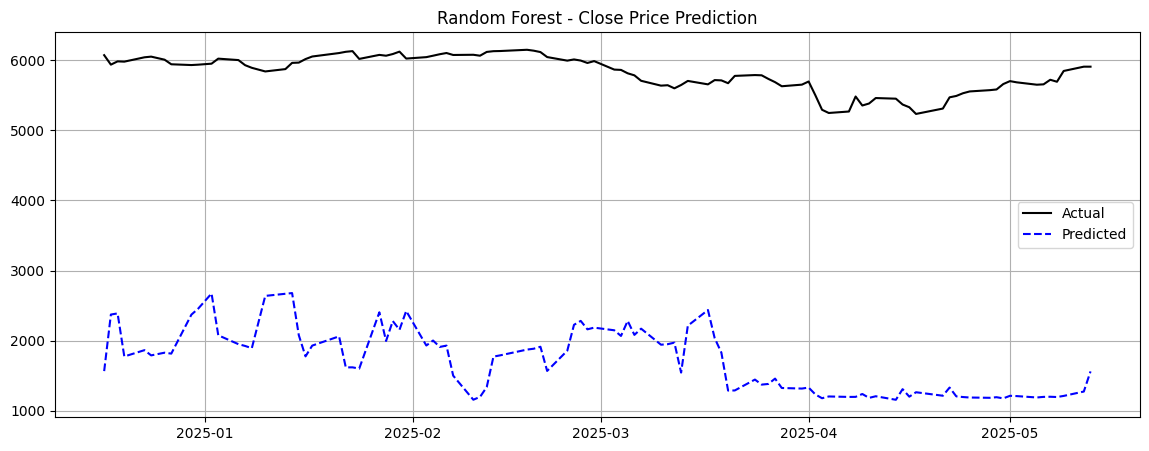

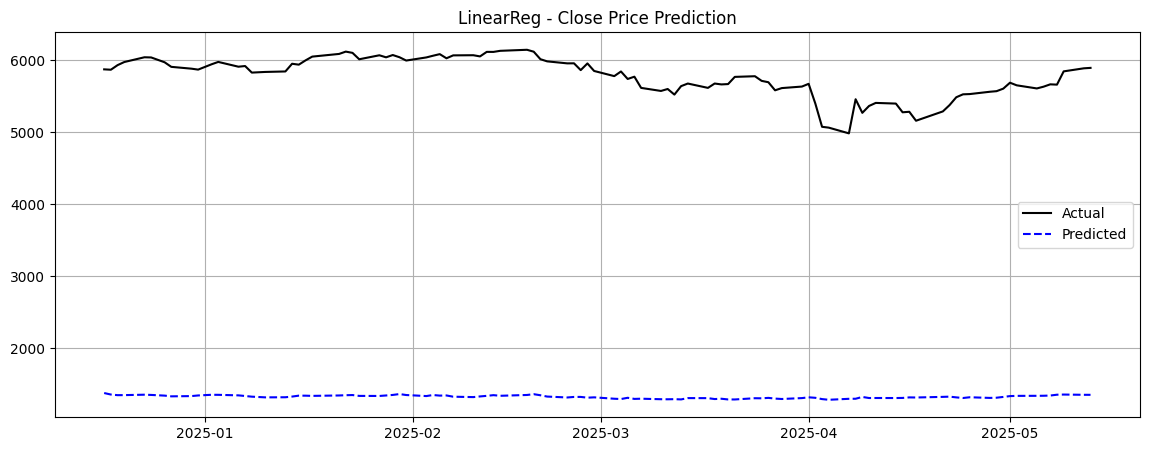

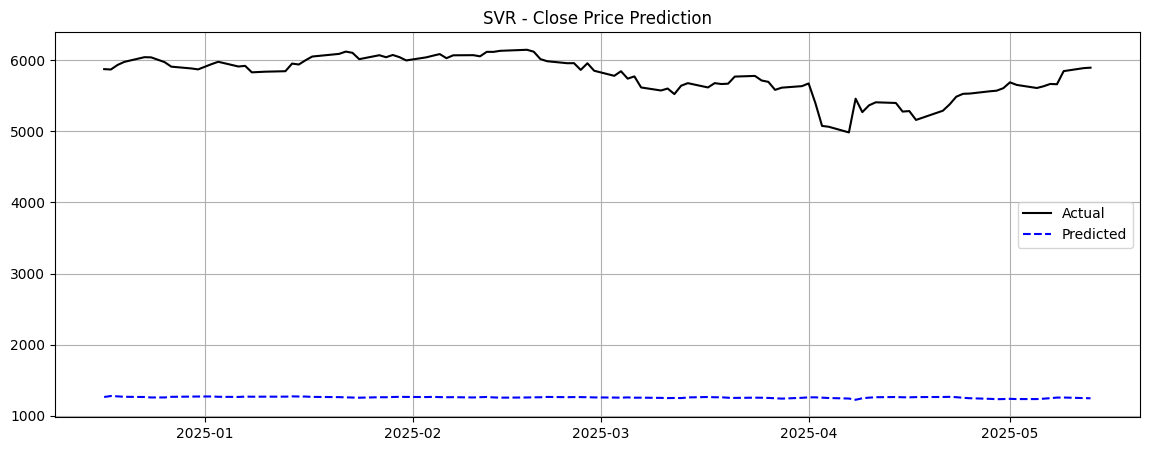

In [64]:

# 6. Plotting

def plot_preds(preds, title, n=100):
    plt.figure(figsize=(14, 5))
    idx = preds.index[-n:]
    plt.plot(idx, preds["Actual"].iloc[-n:], label="Actual", color="black")
    plt.plot(idx, preds["Prediction"].iloc[-n:], label="Predicted", color="blue", linestyle="--")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot Close price prediction for Random Forest
plot_preds(results["Random Forest"]["Close"], "Random Forest - Close Price Prediction")
plot_preds(results["Linear Regression"]["Close"], "LinearReg - Close Price Prediction")
plot_preds(results["SVR"]["Close"], "SVR - Close Price Prediction")


#### Added price to Predictors

In [ ]:
# 1. Load and Preprocess Data
sp500 = yf.Ticker("^GSPC").history(period="max")
sp500 = sp500.loc[datetime(1990, 1, 1, tzinfo=timezone.utc):].copy()
sp500.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)

In [ ]:
# 2. Add Technical Indicators

horizons = [5, 250]
for horizon in horizons:
    sp500[f"Close_Ratio_{horizon}"] = sp500["Close"] / sp500["Close"].rolling(horizon).mean()
    sp500[f"Trend_{horizon}"] = (sp500["Close"].shift(1) < sp500["Close"].shift(0)).rolling(horizon).sum()
    
sp500["RSI"] = RSIIndicator(close=sp500["Close"]).rsi()
macd = MACD(close=sp500["Close"])
sp500["MACD_diff"] = macd.macd_diff()
boll = BollingerBands(close=sp500["Close"])
sp500["bollinger_pct"] = (sp500["Close"] - boll.bollinger_lband()) / (boll.bollinger_hband() - boll.bollinger_lband())

# Add today's Open price
sp500["Open_Price"] = sp500["Open"]

# Shift target to predict tomorrow's Close
sp500["Target_Close"] = sp500["Close"].shift(-1)

# Drop any missing values
sp500.dropna(inplace=True)

In [ ]:
# 3. Setup Features and Targets

predictors = ["Open_Price", "RSI", "MACD_diff", "bollinger_pct","Close_Ratio_5", "Trend_5", "Close_Ratio_250", "Trend_250"]
target = "Target_Close"

In [ ]:
# 4. Train-Test Split

split_index = int(len(sp500) * 0.8)
train = sp500.iloc[:split_index]
test = sp500.iloc[split_index:]

X_train = train[predictors]
y_train = train[target]
X_test = test[predictors]
y_test = test[target]

In [ ]:
# 5. Evaluation Function

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"\n📊 {name}")
    print(f"📉 MSE: {mse:.4f}")
    print(f"📏 MAE: {mae:.4f}")
    print(f"📈 R²: {r2:.4f}")

    return pd.DataFrame({"Actual": y_test, "Prediction": predictions}, index=y_test.index)


📊 Random Forest
📉 MSE: 2616862.7695
📏 MAE: 1315.5127
📈 R²: -1.8066

📊 Linear Regression
📉 MSE: 3148.3571
📏 MAE: 40.4316
📈 R²: 0.9966

📊 SVR
📉 MSE: 5109836.9600
📏 MAE: 1744.7168
📈 R²: -4.4804


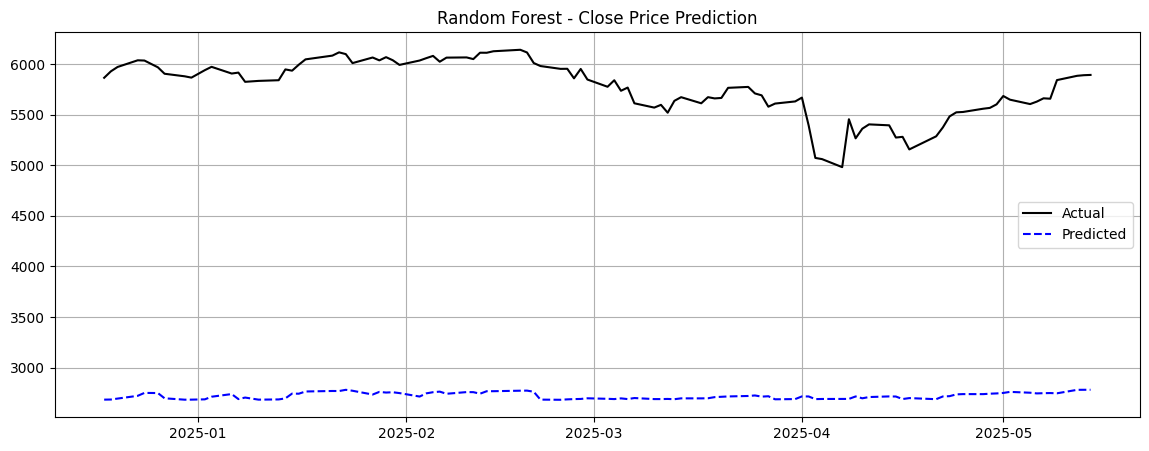

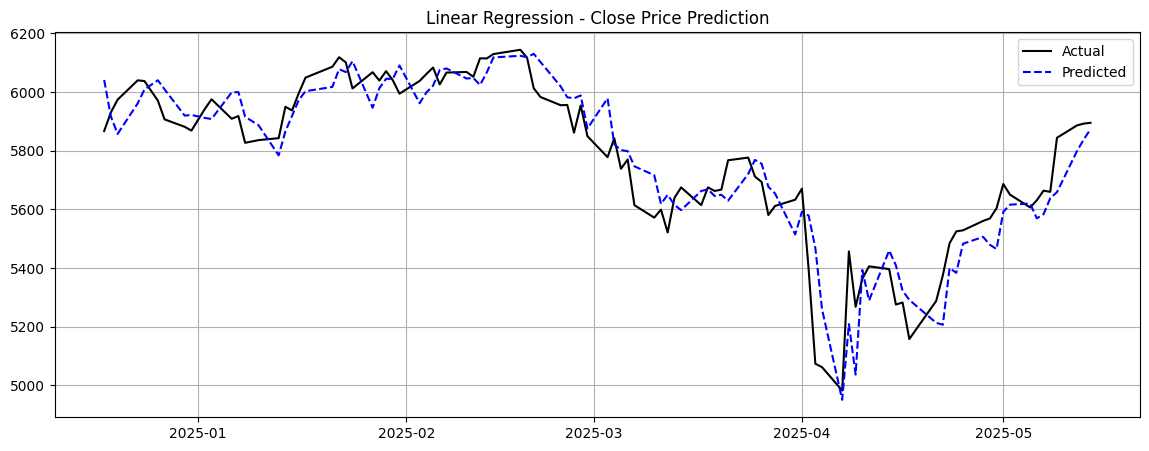

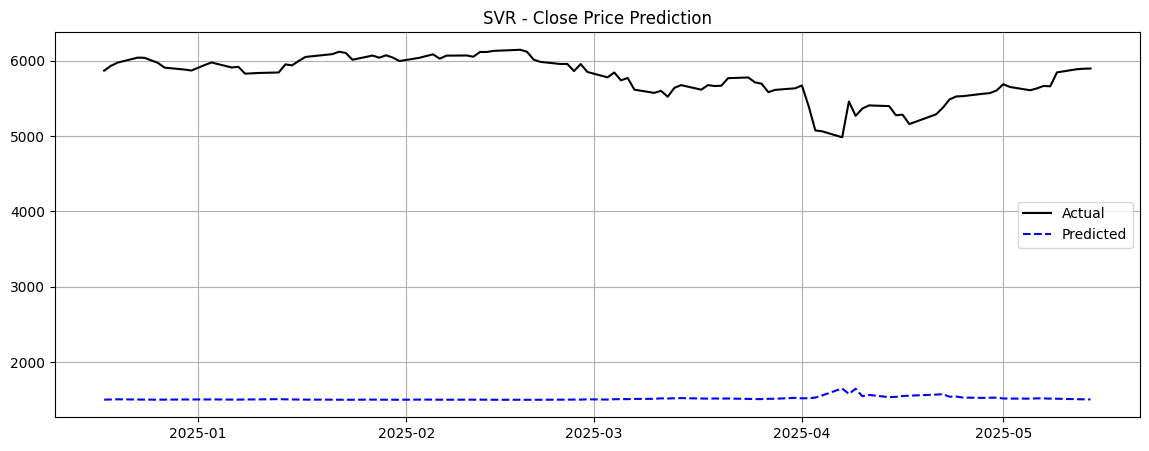

In [ ]:

# 6. Train and Evaluate Models

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(C=100, epsilon=0.5)
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, name)

# 7. Plotting

def plot_preds(preds, title, n=100):
    plt.figure(figsize=(14, 5))
    idx = preds.index[-n:]
    plt.plot(idx, preds["Actual"].iloc[-n:], label="Actual", color="black")
    plt.plot(idx, preds["Prediction"].iloc[-n:], label="Predicted", color="blue", linestyle="--")
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Example: Plot Random Forest results
plot_preds(results["Random Forest"], "Random Forest - Close Price Prediction")
plot_preds(results["Linear Regression"], "Linear Regression - Close Price Prediction")
plot_preds(results["SVR"], "SVR - Close Price Prediction")


We choose the essential_predictors ["Open_Price", "RSI", "MACD_diff", "bollinger_pct","Close_Ratio_5", "Trend_5", "Close_Ratio_250", "Trend_250"] as the list of predicors

#### Taking 5 Day average price instead of closing price

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from datetime import datetime, timezone


# 1. Load and Prepare Data

sp500 = yf.Ticker("^GSPC").history(period="max")
sp500 = sp500.loc["1990-01-01":].copy()
sp500.index = pd.to_datetime(sp500.index, utc=True)
sp500.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)


# 2. Add Technical Indicators

horizons = [5, 250]
for horizon in horizons:
    sp500[f"Close_Ratio_{horizon}"] = sp500["Close"] / sp500["Close"].rolling(horizon).mean()
    sp500[f"Trend_{horizon}"] = (sp500["Close"].shift(1) < sp500["Close"].shift(0)).rolling(horizon).sum()

sp500["RSI"] = RSIIndicator(close=sp500["Close"]).rsi()
macd = MACD(close=sp500["Close"])
sp500["MACD_diff"] = macd.macd_diff()
boll = BollingerBands(close=sp500["Close"])
sp500["bollinger_pct"] = (sp500["Close"] - boll.bollinger_lband()) / (boll.bollinger_hband() - boll.bollinger_lband())

# Today's Open as predictor
sp500["Open_Price"] = sp500["Open"]

In [ ]:

# 3. Create 5-Day Average Close Target

sp500["Close_5d_avg"] = sp500["Close"].shift(-1).rolling(5).mean()

# Drop missing values
sp500.dropna(inplace=True)


# 4. Define Features and Target

predictors = ["Open_Price", "RSI", "MACD_diff", "bollinger_pct",
              "Close_Ratio_5", "Trend_5", "Close_Ratio_250", "Trend_250"]
target = "Close_5d_avg"

X = sp500[predictors]
y = sp500[target]


In [ ]:

# 5. Train-Test Split

split_index = int(0.6 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


# 6. Evaluation Function

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)

    print(f"\n📊 {name}")
    print(f"📉 MSE: {mse:.2f}")
    print(f"📏 MAE: {mae:.2f}")
    print(f"📈 R²: {r2:.4f}")

    return pd.DataFrame({"Actual": y_test, "Prediction": predictions}, index=y_test.index)


📊 Random Forest
📉 MSE: 3681435.20
📏 MAE: 1453.37
📈 R²: -1.2370

📊 Linear Regression
📉 MSE: 435.37
📏 MAE: 13.18
📈 R²: 0.9997

📊 SVR
📉 MSE: 5286018.20
📏 MAE: 1691.57
📈 R²: -2.2120


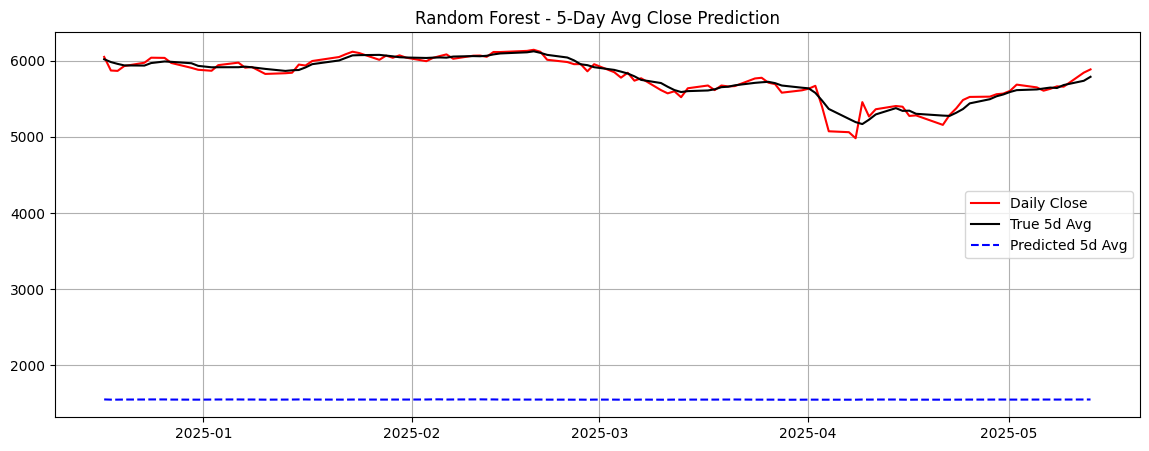

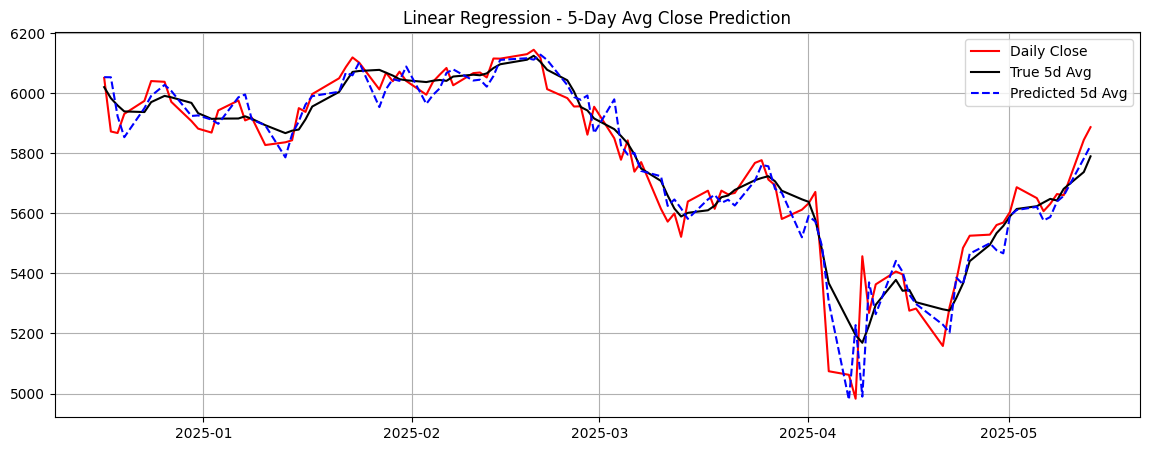

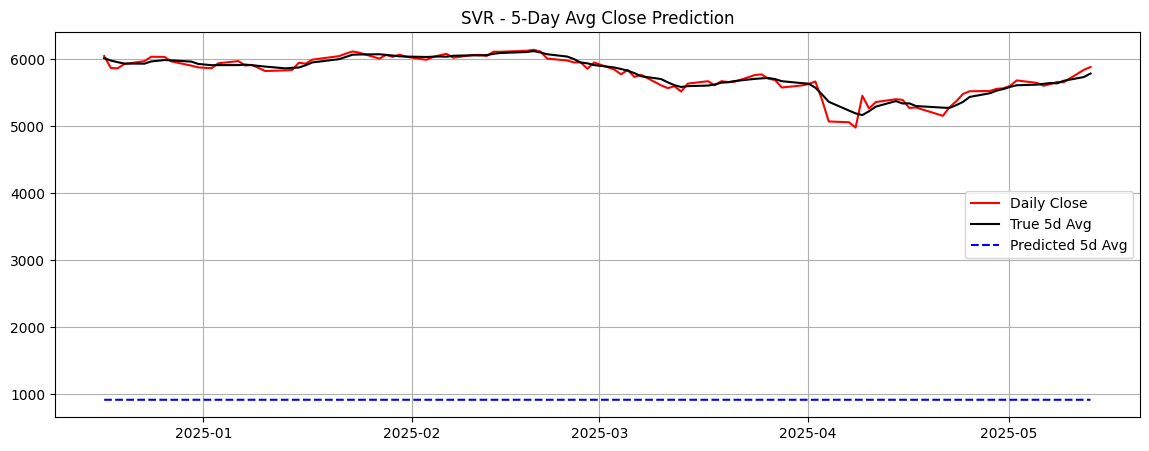

In [ ]:


# 7. Train and Evaluate Models

models = {
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Linear Regression": LinearRegression(),
    "SVR": SVR(C=100, epsilon=0.5)
}

results = {}
for name, model in models.items():
    results[name] = evaluate_model(model, name)


# 8. Plot Predictions

def plot_preds(preds, title, n=100):
    plt.figure(figsize=(14, 5))
    
    idx = preds.index[-n:]
    
    # Plot actual daily close
    plt.plot(sp500.loc[idx, "Close"], label="Daily Close", color="red")
    
    # Plot true 5-day average close
    plt.plot(preds["Actual"].iloc[-n:], label="True 5d Avg", color="black")
    
    # Plot predicted 5-day average close
    plt.plot(preds["Prediction"].iloc[-n:], label="Predicted 5d Avg", linestyle="--", color="blue")
    
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


# Example: Plot results
plot_preds(results["Random Forest"], "Random Forest - 5-Day Avg Close Prediction")
plot_preds(results["Linear Regression"], "Linear Regression - 5-Day Avg Close Prediction")
plot_preds(results["SVR"], "SVR - 5-Day Avg Close Prediction")


### Linear Regression performs well so choosing that for now
#### -- Now predicting min max and avg prices

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from datetime import datetime, timezone


# 1. Load and Prepare Data

sp500 = yf.Ticker("^GSPC").history(period="max")
sp500 = sp500.loc["1990-01-01":].copy()
sp500.index = pd.to_datetime(sp500.index, utc=True)
sp500.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)


# 2. Add Technical Indicators

horizons = [5, 250]
for horizon in horizons:
    sp500[f"Close_Ratio_{horizon}"] = sp500["Close"] / sp500["Close"].rolling(horizon).mean()
    sp500[f"Trend_{horizon}"] = (sp500["Close"].shift(1) < sp500["Close"].shift(0)).rolling(horizon).sum()

sp500["RSI"] = RSIIndicator(close=sp500["Close"]).rsi()
macd = MACD(close=sp500["Close"])
sp500["MACD_diff"] = macd.macd_diff()
boll = BollingerBands(close=sp500["Close"])
sp500["bollinger_pct"] = (sp500["Close"] - boll.bollinger_lband()) / (boll.bollinger_hband() - boll.bollinger_lband())
sp500["Open_Price"] = sp500["Open"]


# 3. Create Multi-Output Targets

sp500["Close_5d_avg"] = sp500["Close"].shift(-1).rolling(5).mean()
sp500["Close_5d_min"] = sp500["Close"].shift(-1).rolling(5).min()
sp500["Close_5d_max"] = sp500["Close"].shift(-1).rolling(5).max()
sp500.dropna(inplace=True)

In [ ]:

# 4. Define Features and Targets

predictors = ["Open_Price", "RSI", "MACD_diff", "bollinger_pct",
              "Close_Ratio_5", "Trend_5", "Close_Ratio_250", "Trend_250"]
targets = ["Close_5d_min", "Close_5d_avg", "Close_5d_max"]

X = sp500[predictors]
y = sp500[targets]


# 5. Train-Test Split

split_index = int(0.6 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [ ]:

# 6. Train MultiOutput Linear Regression

model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, y_train)

predictions = model.predict(X_test)
pred_df = pd.DataFrame(predictions, columns=targets, index=y_test.index)



✅ Model saved as linear_model_5d_range.pkl

📊 Linear Regression - 5-Day Range Prediction

🔹 Close_5d_min
📉 MSE: 1154.64
📏 MAE: 23.47
📈 R²: 0.9993

🔹 Close_5d_avg
📉 MSE: 435.51
📏 MAE: 13.18
📈 R²: 0.9997

🔹 Close_5d_max
📉 MSE: 1151.34
📏 MAE: 21.29
📈 R²: 0.9993


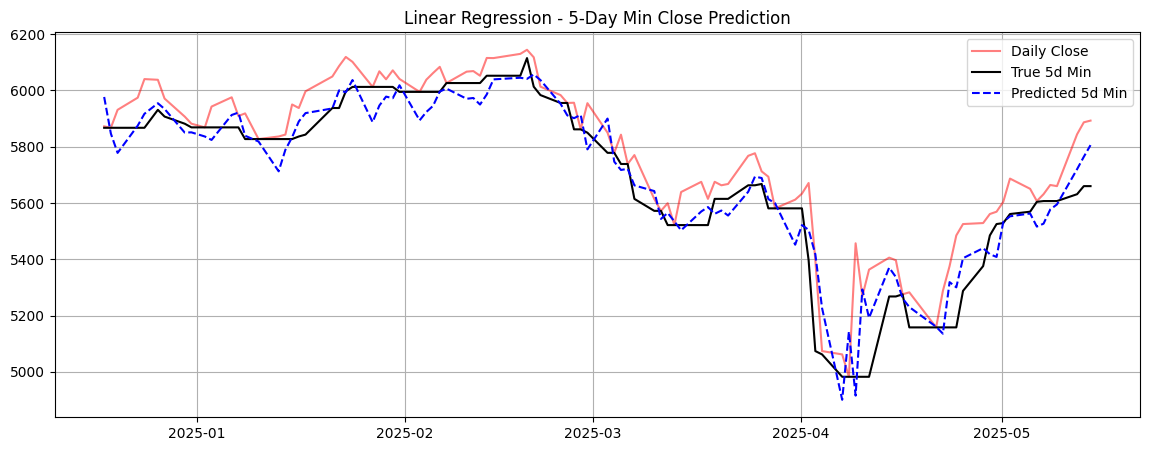

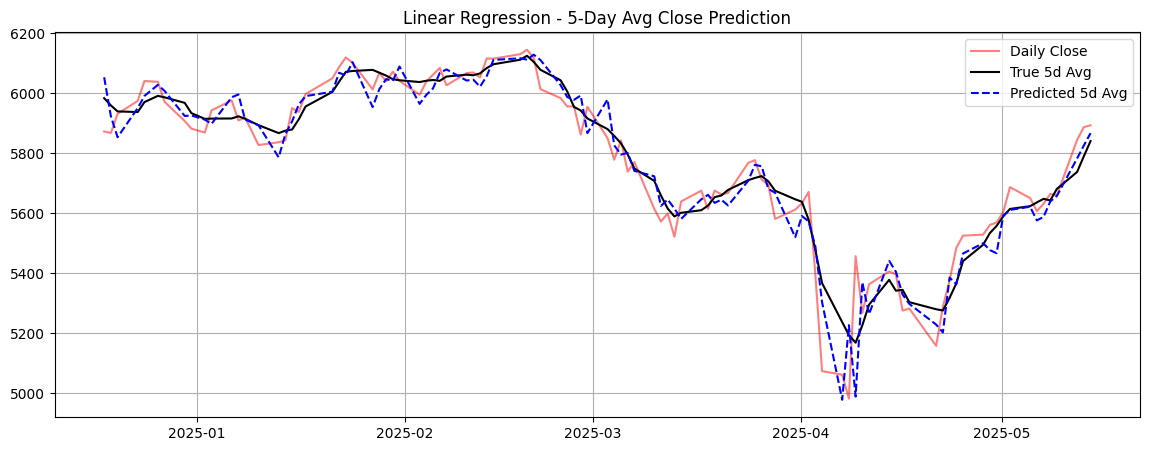

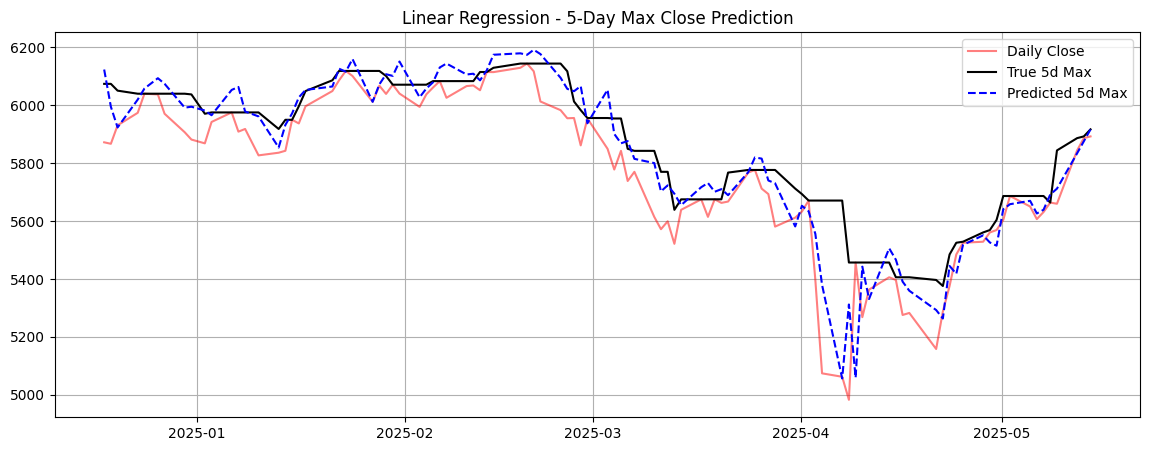

In [ ]:

import joblib

# Save the trained model
joblib.dump({
    "model": model,
    "predictors": predictors,
    "targets": targets
}, "linear_model_5d_price.pkl")
print("✅ Model saved as linear_model_5d_range.pkl")

# 7. Evaluate Model

print("\n📊 Linear Regression - 5-Day Range Prediction")
for col in targets:
    mse = mean_squared_error(y_test[col], pred_df[col])
    mae = mean_absolute_error(y_test[col], pred_df[col])
    r2 = r2_score(y_test[col], pred_df[col])
    print(f"\n🔹 {col}")
    print(f"📉 MSE: {mse:.2f}")
    print(f"📏 MAE: {mae:.2f}")
    print(f"📈 R²: {r2:.4f}")


# 8. Plotting Function

def plot_range(actual, predicted, close, label, n=100):
    plt.figure(figsize=(14, 5))
    idx = predicted.index[-n:]
    plt.plot(close.loc[idx], label="Daily Close", color="red", alpha=0.5)
    plt.plot(actual.loc[idx], label=f"True 5d {label}", color="black")
    plt.plot(predicted.loc[idx], label=f"Predicted 5d {label}", linestyle="--", color="blue")
    plt.title(f"Linear Regression - 5-Day {label} Close Prediction")
    plt.legend()
    plt.grid(True)
    plt.show()


# 9. Plot All Three

plot_range(y_test["Close_5d_min"], pred_df["Close_5d_min"], sp500["Close"], "Min")
plot_range(y_test["Close_5d_avg"], pred_df["Close_5d_avg"], sp500["Close"], "Avg")
plot_range(y_test["Close_5d_max"], pred_df["Close_5d_max"], sp500["Close"], "Max")


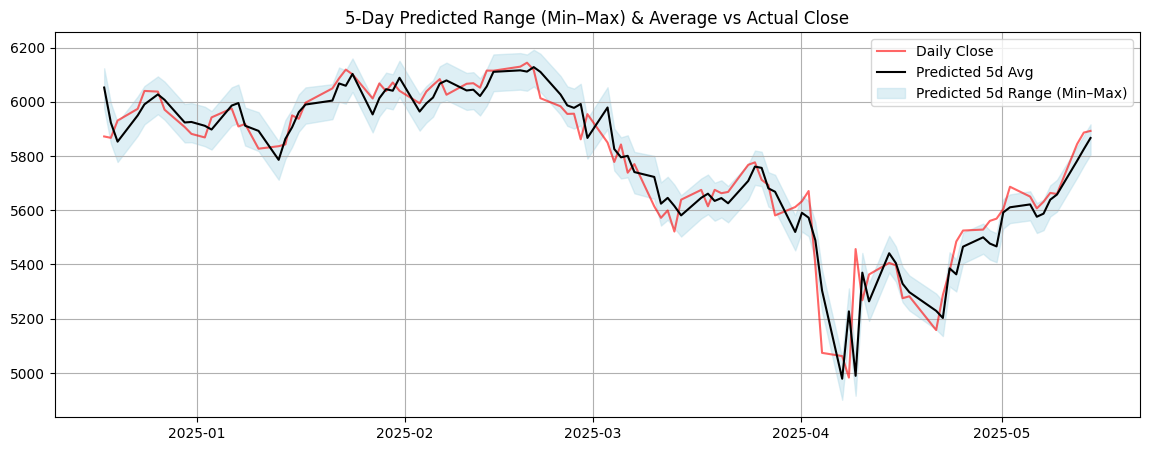

In [ ]:

# 8. Combined Plotting Function

def plot_combined_ranges_shaded(pred_df, close, n=100):
    plt.figure(figsize=(14, 5))
    idx = pred_df.index[-n:]

    # Daily Close (actual)
    plt.plot(close.loc[idx], label="Daily Close", color="red", alpha=0.6)

    # Predicted 5d average
    plt.plot(pred_df["Close_5d_avg"].loc[idx], label="Predicted 5d Avg", color="black", linestyle="-")

    # Shaded band between predicted min and max
    plt.fill_between(
        idx,
        pred_df["Close_5d_min"].loc[idx],
        pred_df["Close_5d_max"].loc[idx],
        color="lightblue",
        alpha=0.4,
        label="Predicted 5d Range (Min–Max)"
    )

    plt.title("5-Day Predicted Range (Min–Max) & Average vs Actual Close")
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the Updated Function

plot_combined_ranges_shaded(pred_df, sp500["Close"])




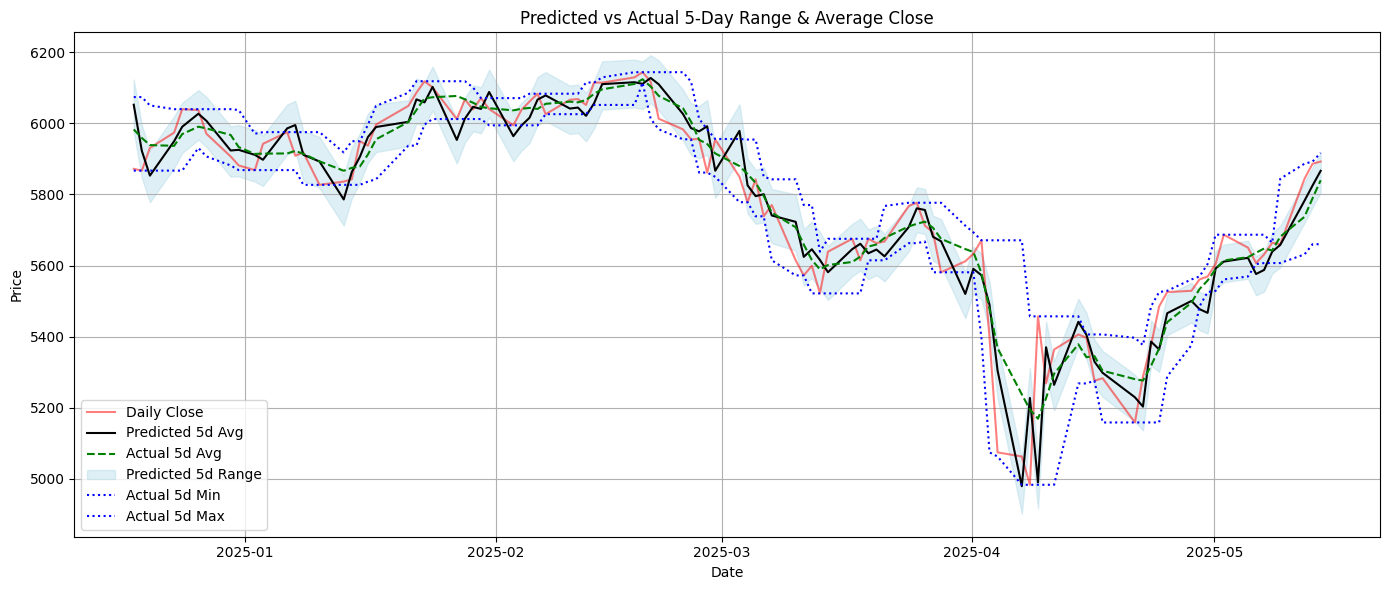

In [27]:
def plot_combined_ranges_shaded(pred_df, actual_df, close, n=100):
    plt.figure(figsize=(14, 6))
    idx = pred_df.index[-n:]

    # Daily Close
    plt.plot(close.loc[idx], label="Daily Close", color="red", alpha=0.5)

    # Predicted 5d Avg
    plt.plot(pred_df["Close_5d_avg"].loc[idx], label="Predicted 5d Avg", color="black", linestyle="-")

    # Actual 5d Avg
    plt.plot(actual_df["Close_5d_avg"].loc[idx], label="Actual 5d Avg", color="green", linestyle="dashed")

    # Shaded predicted range
    plt.fill_between(
        idx,
        pred_df["Close_5d_min"].loc[idx],
        pred_df["Close_5d_max"].loc[idx],
        color="lightblue",
        alpha=0.4,
        label="Predicted 5d Range"
    )

    # Actual 5d min/max as lines
    plt.plot(actual_df["Close_5d_min"].loc[idx], label="Actual 5d Min", color="blue", linestyle="dotted")
    plt.plot(actual_df["Close_5d_max"].loc[idx], label="Actual 5d Max", color="blue", linestyle="dotted")

    plt.title("Predicted vs Actual 5-Day Range & Average Close")
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_combined_ranges_shaded(pred_df, y_test, sp500["Close"])


### Training Linear Regression for each stock low high and avg and packaging it all together using MultiOutputRegressor


🔍 Processing AAPL...
✅ Model trained and added for AAPL


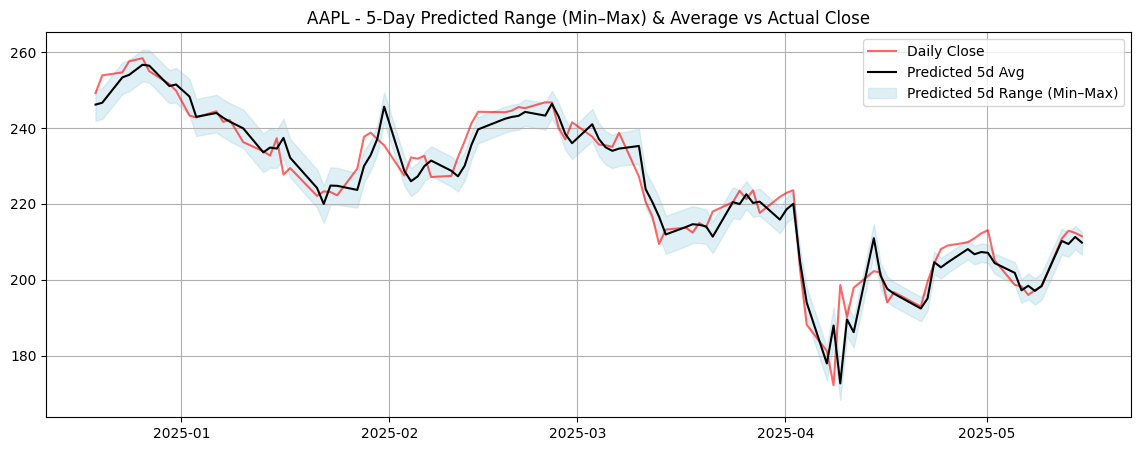


🔍 Processing MSFT...
✅ Model trained and added for MSFT


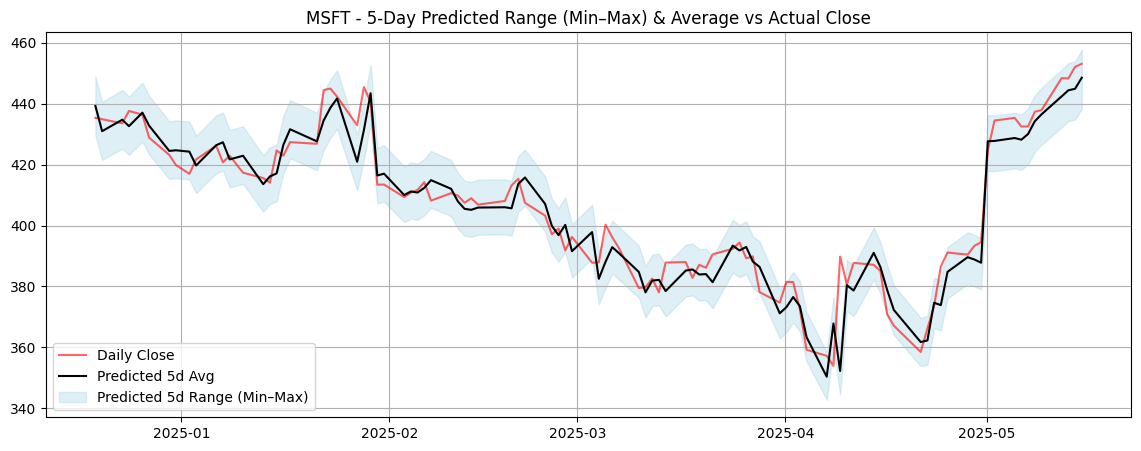


🔍 Processing TSLA...
✅ Model trained and added for TSLA


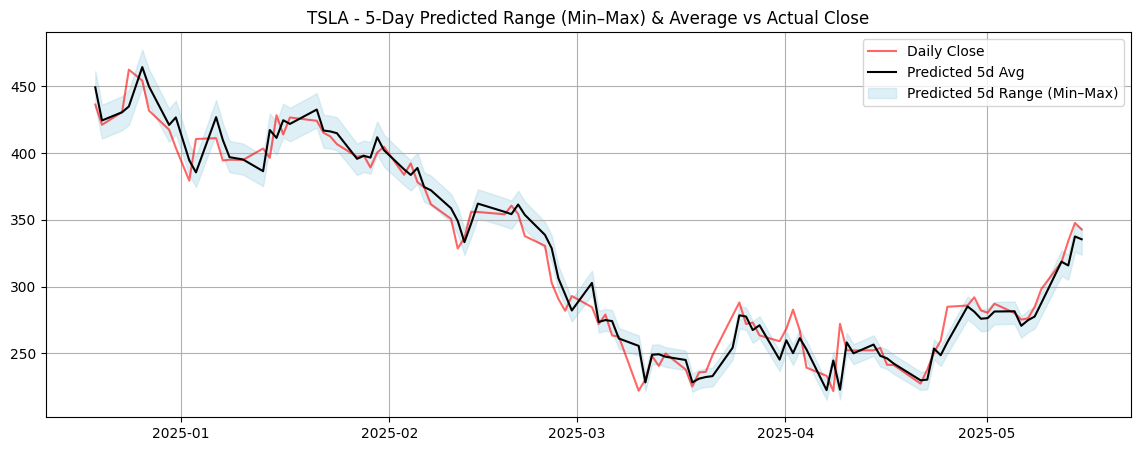


🔍 Processing NVDA...
✅ Model trained and added for NVDA


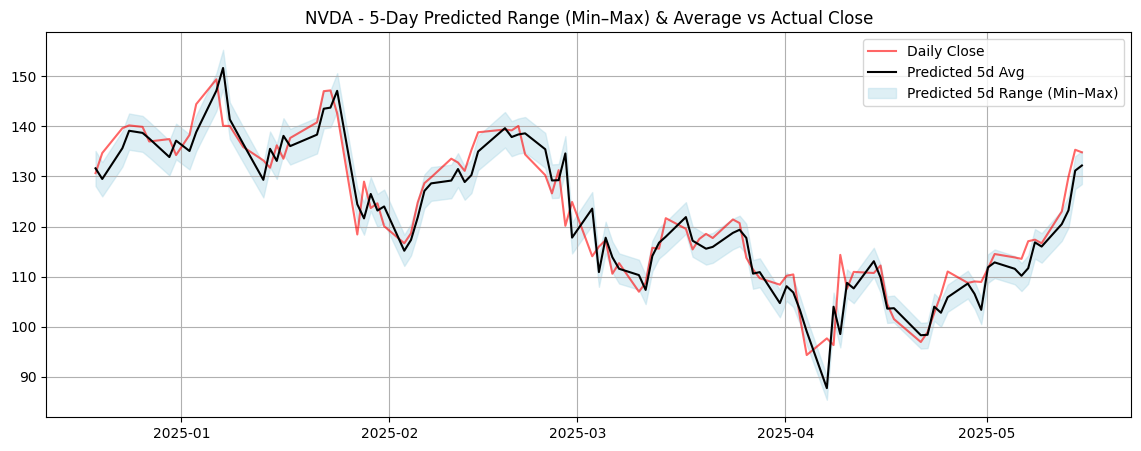


🔍 Processing AMZN...
✅ Model trained and added for AMZN


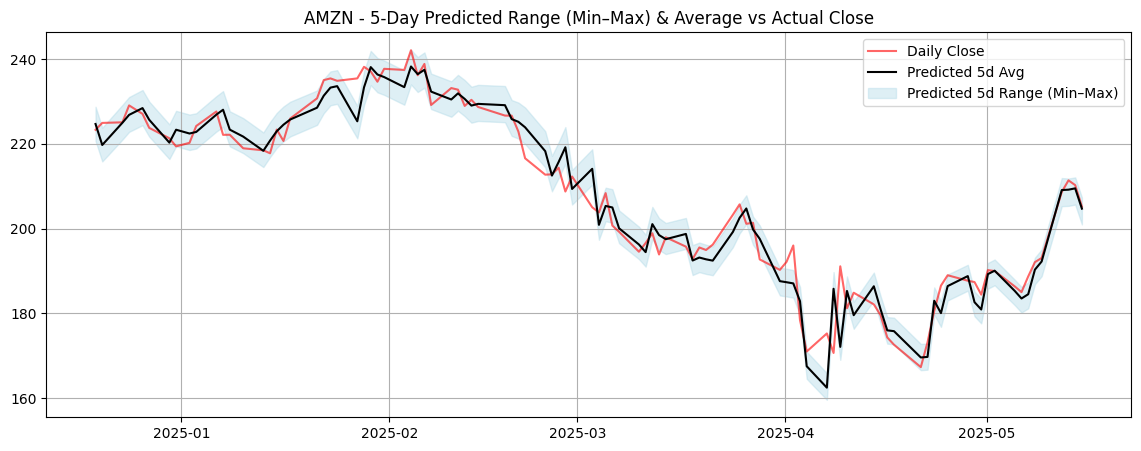


🔍 Processing GOOGL...
✅ Model trained and added for GOOGL


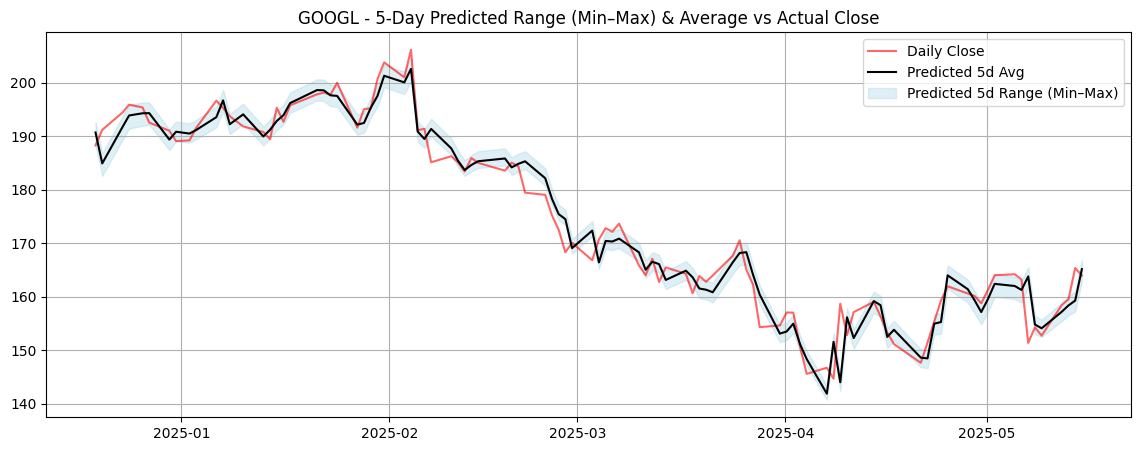


🔍 Processing META...
✅ Model trained and added for META


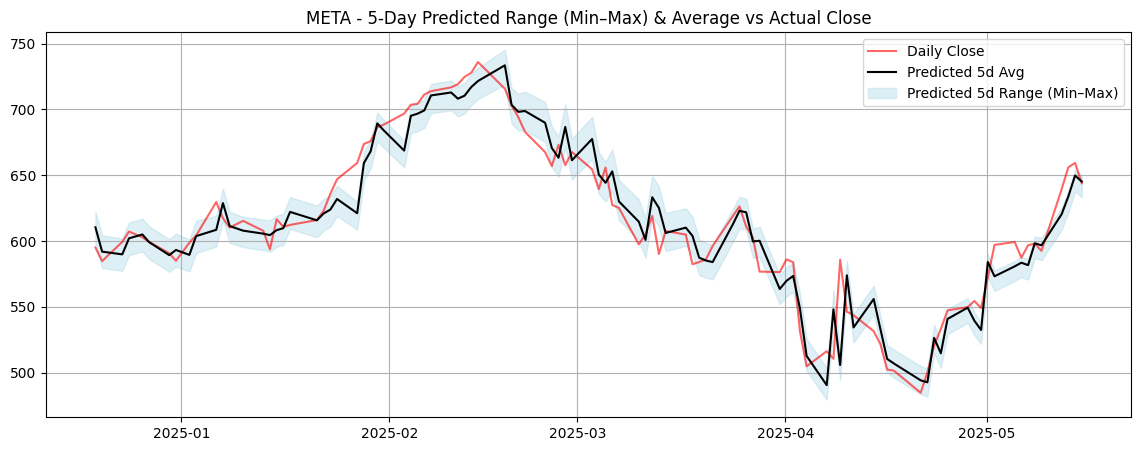


🔍 Processing SPY...
✅ Model trained and added for SPY


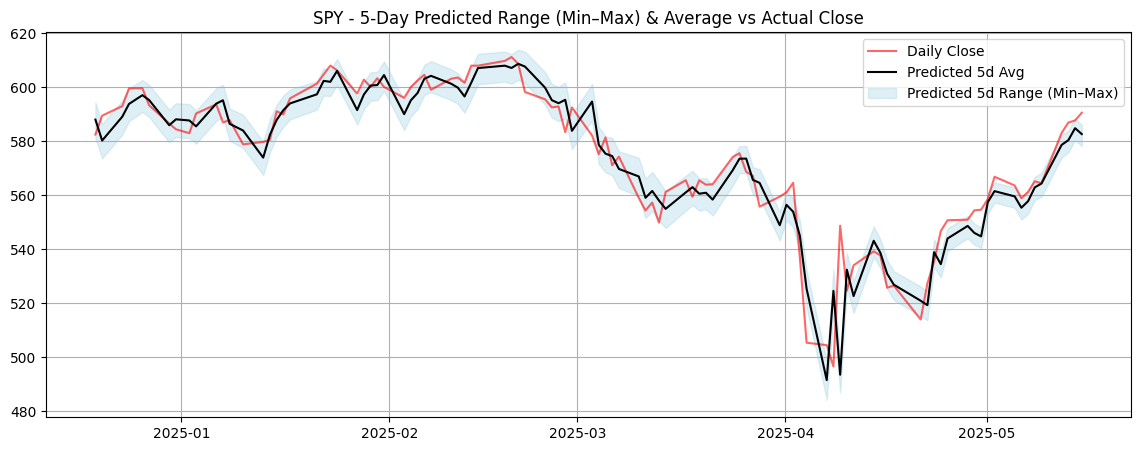


✅ All models saved to models_per_stock.pkl


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.volatility import AverageTrueRange
from datetime import datetime, timezone
import joblib
import os

# Train and Save Models for Each Stock

stocks = ["AAPL", "MSFT", "TSLA", "NVDA", "AMZN", "GOOGL", "META", "SPY"]
model_dict = {}

for symbol in stocks:
    print(f"\n🔍 Processing {symbol}...")
    df = yf.Ticker(symbol).history(period="max")
    df = df.loc["1990-01-01":].copy()
    df.index = pd.to_datetime(df.index, utc=True)
    df.drop(["Dividends", "Stock Splits"], axis=1, inplace=True, errors='ignore')

    # Add Technical Indicators
    horizons = [5, 250]
    for horizon in horizons:
        df[f"Close_Ratio_{horizon}"] = df["Close"] / df["Close"].rolling(horizon).mean()
        df[f"Trend_{horizon}"] = (df["Close"].shift(1) < df["Close"]).rolling(horizon).sum()

    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    macd = MACD(close=df["Close"])
    df["MACD_diff"] = macd.macd_diff()
    boll = BollingerBands(close=df["Close"])
    df["bollinger_pct"] = (df["Close"] - boll.bollinger_lband()) / (boll.bollinger_hband() - boll.bollinger_lband())
    df["Open_Price"] = df["Open"]

    # Multi-Output Targets
    df["Close_5d_avg"] = df["Close"].shift(-1).rolling(5).mean()
    df["Close_5d_min"] = df["Close"].shift(-1).rolling(5).min()
    df["Close_5d_max"] = df["Close"].shift(-1).rolling(5).max()
    df.dropna(inplace=True)

    predictors = ["Open_Price", "RSI", "MACD_diff", "bollinger_pct",
                  "Close_Ratio_5", "Trend_5", "Close_Ratio_250", "Trend_250"]
    targets = ["Close_5d_min", "Close_5d_avg", "Close_5d_max"]

    try:
        X = df[predictors]
        y = df[targets]
        split_index = int(0.6 * len(X))
        X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
        y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

        model = MultiOutputRegressor(LinearRegression())
        model.fit(X_train, y_train)

        model_dict[symbol] = {
            "model": model,
            "predictors": predictors,
            "targets": targets
        }

        print(f"✅ Model trained and added for {symbol}")


        # Plot Combined Range with Shading

        pred = model.predict(X_test)
        pred_df = pd.DataFrame(pred, columns=targets, index=y_test.index)

        def plot_combined_ranges_shaded(pred_df, close, n=100):
            plt.figure(figsize=(14, 5))
            idx = pred_df.index[-n:]
            plt.plot(close.loc[idx], label="Daily Close", color="red", alpha=0.6)
            plt.plot(pred_df["Close_5d_avg"].loc[idx], label="Predicted 5d Avg", color="black", linestyle="-")
            plt.fill_between(
                idx,
                pred_df["Close_5d_min"].loc[idx],
                pred_df["Close_5d_max"].loc[idx],
                color="lightblue",
                alpha=0.4,
                label="Predicted 5d Range (Min–Max)"
            )
            plt.title(f"{symbol} - 5-Day Predicted Range (Min–Max) & Average vs Actual Close")
            plt.legend()
            plt.grid(True)
            plt.show()

        plot_combined_ranges_shaded(pred_df, df["Close"])

    except Exception as e:
        print(f"⚠️ Skipping {symbol} due to error: {e}")

# Save all models
joblib.dump(model_dict, "models_per_stock.pkl")
print("\n✅ All models saved to models_per_stock.pkl")


In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands
from ta.volatility import AverageTrueRange
from datetime import datetime, timezone
import joblib
import os

# Train and Save Models for Each Stock

stocks = ["AAPL", "MSFT", "TSLA", "NVDA", "AMZN", "GOOGL", "META", "SPY"]
model_dict = {}

for symbol in stocks:
    print(f"\n🔍 Processing {symbol}...")
    df = yf.Ticker(symbol).history(period="max")
    df = df.loc["1990-01-01":].copy()
    df.index = pd.to_datetime(df.index, utc=True)
    df.drop(["Dividends", "Stock Splits"], axis=1, inplace=True, errors='ignore')

    # Add Technical Indicators
    horizons = [5, 250]
    for horizon in horizons:
        df[f"Close_Ratio_{horizon}"] = df["Close"] / df["Close"].rolling(horizon).mean()
        df[f"Trend_{horizon}"] = (df["Close"].shift(1) < df["Close"]).rolling(horizon).sum()

    df["RSI"] = RSIIndicator(close=df["Close"]).rsi()
    macd = MACD(close=df["Close"])
    df["MACD_diff"] = macd.macd_diff()
    boll = BollingerBands(close=df["Close"])
    df["bollinger_pct"] = (df["Close"] - boll.bollinger_lband()) / (boll.bollinger_hband() - boll.bollinger_lband())
    df["Open_Price"] = df["Open"]

    # Multi-Output Targets
    df["Close_5d_avg"] = df["Close"].shift(-1).rolling(5).mean()
    df["Close_5d_min"] = df["Close"].shift(-1).rolling(5).min()
    df["Close_5d_max"] = df["Close"].shift(-1).rolling(5).max()
    df.dropna(inplace=True)

    predictors = ["Open_Price", "RSI", "MACD_diff", "bollinger_pct",
                  "Close_Ratio_5", "Trend_5", "Close_Ratio_250", "Trend_250"]
    targets = ["Close_5d_min", "Close_5d_avg", "Close_5d_max"]

    try:
        X = df[predictors]
        y = df[targets]

        model = MultiOutputRegressor(LinearRegression())
        model.fit(X,y)

        model_dict[symbol] = {
            "model": model,
            "predictors": predictors,
            "targets": targets
        }

        print(f"✅ Model trained and added for {symbol}")


    except Exception as e:
        print(f"⚠️ Skipping {symbol} due to error: {e}")

# Save all models
joblib.dump(model_dict, "models_per_stock_FD.pkl")
print("\n✅ All models saved to models_per_stock.pkl")



🔍 Processing AAPL...
✅ Model trained and added for AAPL

🔍 Processing MSFT...
✅ Model trained and added for MSFT

🔍 Processing TSLA...
✅ Model trained and added for TSLA

🔍 Processing NVDA...
✅ Model trained and added for NVDA

🔍 Processing AMZN...
✅ Model trained and added for AMZN

🔍 Processing GOOGL...
✅ Model trained and added for GOOGL

🔍 Processing META...
✅ Model trained and added for META

🔍 Processing SPY...
✅ Model trained and added for SPY

✅ All models saved to models_per_stock.pkl


### Testing with 5d returns Instead of 5d prices
#### -- 5 Day returns is the percentage change in 5 days

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from ta.momentum import RSIIndicator
from ta.trend import MACD
from ta.volatility import BollingerBands


# 1. Load and Prepare Data

sp500 = yf.Ticker("^GSPC").history(period="max")
sp500 = sp500.loc["1990-01-01":].copy()
sp500.index = pd.to_datetime(sp500.index, utc=True)
sp500.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)


# 2. Add Technical Indicators

horizons = [5, 250]
for horizon in horizons:
    sp500[f"Close_Ratio_{horizon}"] = sp500["Close"] / sp500["Close"].rolling(horizon).mean()
    sp500[f"Trend_{horizon}"] = (sp500["Close"].shift(1) < sp500["Close"].shift(0)).rolling(horizon).sum()

sp500["RSI"] = RSIIndicator(close=sp500["Close"]).rsi()
macd = MACD(close=sp500["Close"])
sp500["MACD_diff"] = macd.macd_diff()
boll = BollingerBands(close=sp500["Close"])
sp500["bollinger_pct"] = (sp500["Close"] - boll.bollinger_lband()) / (boll.bollinger_hband() - boll.bollinger_lband())
sp500["Open_Price"] = sp500["Open"]

# 3. Create Multi-Output Return Targets

sp500["Low_5d_return"]  = (sp500["Close"].shift(-1).rolling(5).min() / sp500["Close"]) - 1
sp500["Avg_5d_return"]  = (sp500["Close"].shift(-1).rolling(5).mean() / sp500["Close"]) - 1
sp500["High_5d_return"] = (sp500["Close"].shift(-1).rolling(5).max() / sp500["Close"]) - 1

sp500.dropna(inplace=True)

In [ ]:


# 4. Define Features and Targets

predictors = ["Open_Price", "RSI", "MACD_diff", "bollinger_pct",
              "Close_Ratio_5", "Trend_5", "Close_Ratio_250", "Trend_250"]
targets = ["Low_5d_return", "Avg_5d_return", "High_5d_return"]

X = sp500[predictors]
y = sp500[targets]


# 5. Train-Test Split

split_index = int(0.6 * len(X))
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [ ]:

# 6. Train MultiOutput Linear Regression

model = MultiOutputRegressor(LinearRegression())
model.fit(X_train, y_train)

predictions = model.predict(X_test)
pred_df = pd.DataFrame(predictions, columns=targets, index=y_test.index)


📊 Linear Regression - 5-Day Return Prediction

🔹 Low_5d_return
📉 MSE: 0.000128
📏 MAE: 0.0093
📈 R²: 0.0008

🔹 Avg_5d_return
📉 MSE: 0.000010
📏 MAE: 0.0021
📈 R²: 0.8648

🔹 High_5d_return
📉 MSE: 0.000074
📏 MAE: 0.0070
📈 R²: 0.5667


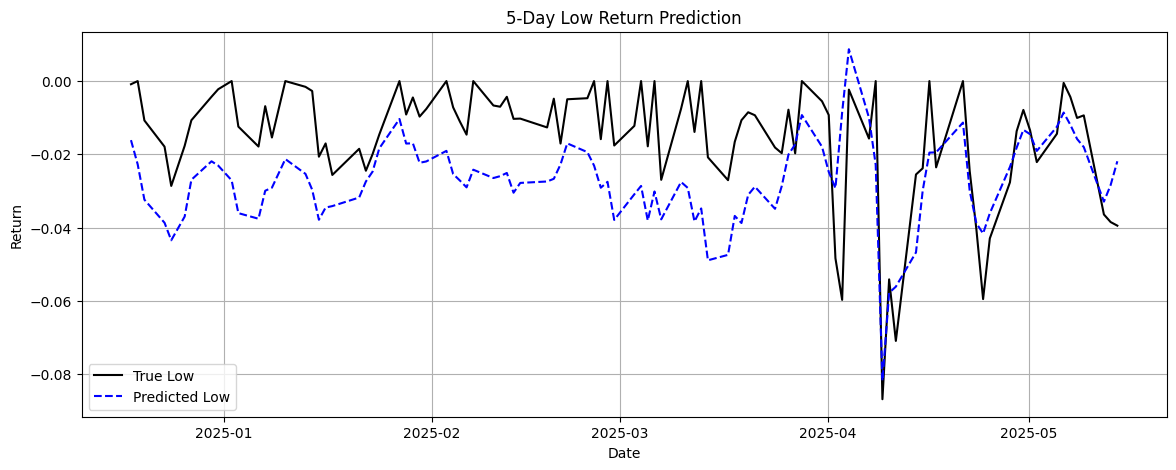

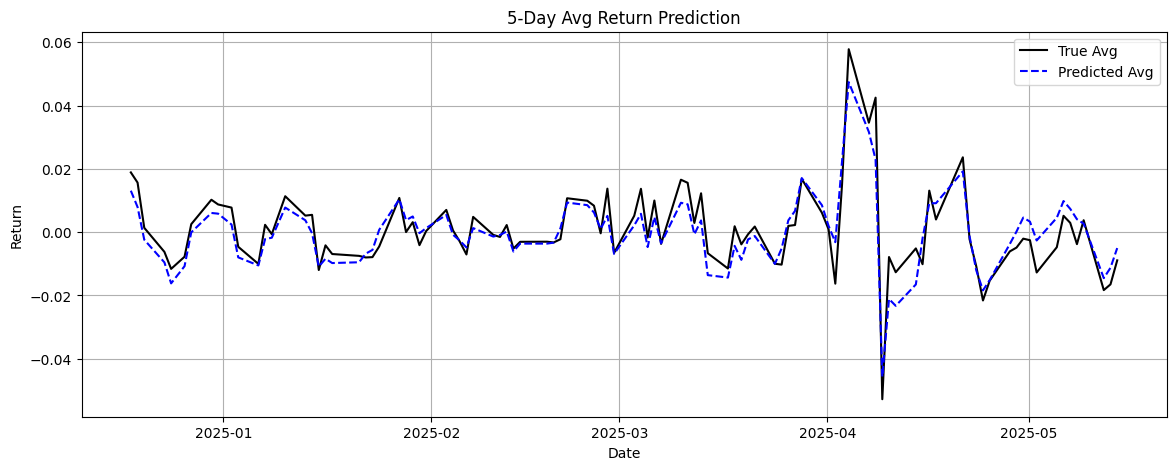

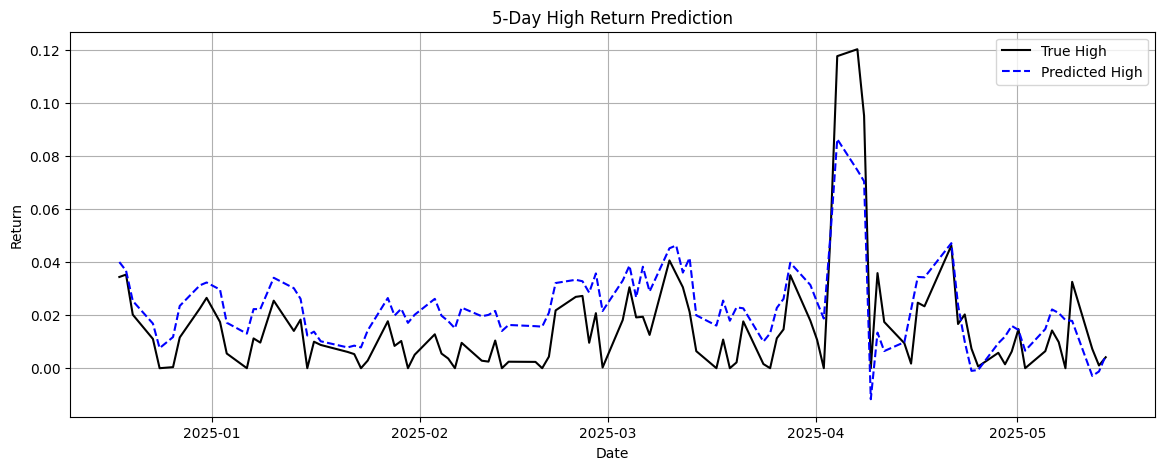

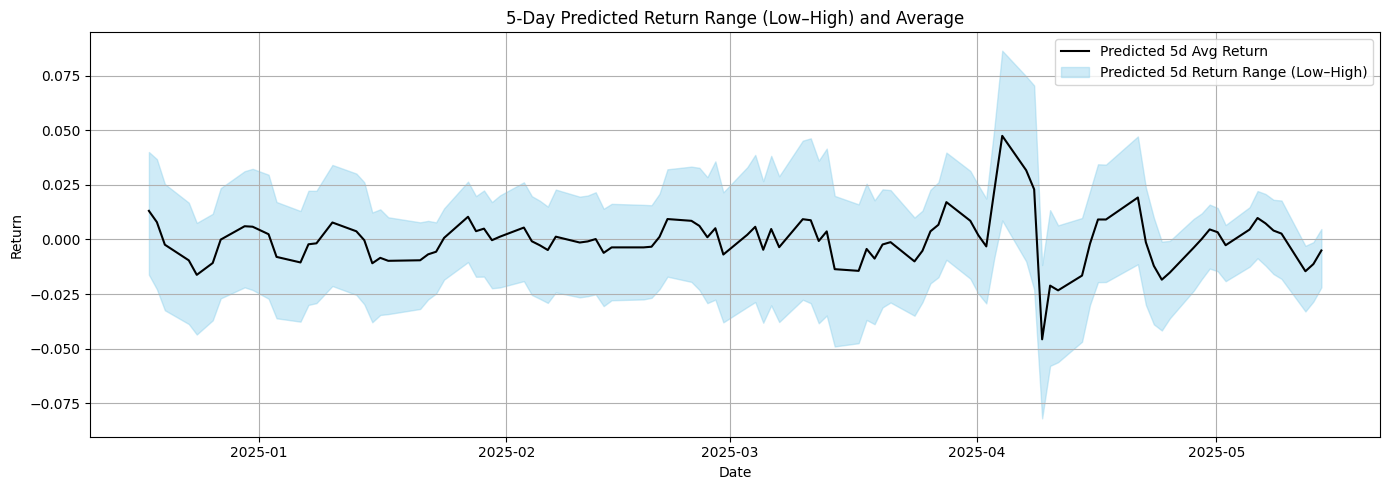

In [ ]:


# 7. Evaluation

print("\n📊 Linear Regression - 5-Day Return Prediction")
for col in targets:
    mse = mean_squared_error(y_test[col], pred_df[col])
    mae = mean_absolute_error(y_test[col], pred_df[col])
    r2 = r2_score(y_test[col], pred_df[col])
    print(f"\n🔹 {col}")
    print(f"📉 MSE: {mse:.6f}")
    print(f"📏 MAE: {mae:.4f}")
    print(f"📈 R²: {r2:.4f}")


# 8. Plot Individual Return Components

def plot_return_component(y_true, y_pred, label, n=100):
    idx = y_true.index[-n:]
    plt.figure(figsize=(14, 5))
    plt.plot(idx, y_true.loc[idx], label=f"True {label}", color="black")
    plt.plot(idx, y_pred.loc[idx], label=f"Predicted {label}", linestyle="--", color="blue")
    plt.title(f"5-Day {label} Return Prediction")
    plt.ylabel("Return")
    plt.xlabel("Date")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_return_component(y_test["Low_5d_return"], pred_df["Low_5d_return"], "Low")
plot_return_component(y_test["Avg_5d_return"], pred_df["Avg_5d_return"], "Avg")
plot_return_component(y_test["High_5d_return"], pred_df["High_5d_return"], "High")


# 9. Combined Shaded Plot

def plot_combined_return_ranges(pred_df, n=100):
    idx = pred_df.index[-n:]
    plt.figure(figsize=(14, 5))

    plt.plot(idx, pred_df["Avg_5d_return"].loc[idx], label="Predicted 5d Avg Return", color="black")

    plt.fill_between(
        idx,
        pred_df["Low_5d_return"].loc[idx],
        pred_df["High_5d_return"].loc[idx],
        color="skyblue",
        alpha=0.4,
        label="Predicted 5d Return Range (Low–High)"
    )

    plt.title("5-Day Predicted Return Range (Low–High) and Average")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_combined_return_ranges(pred_df)


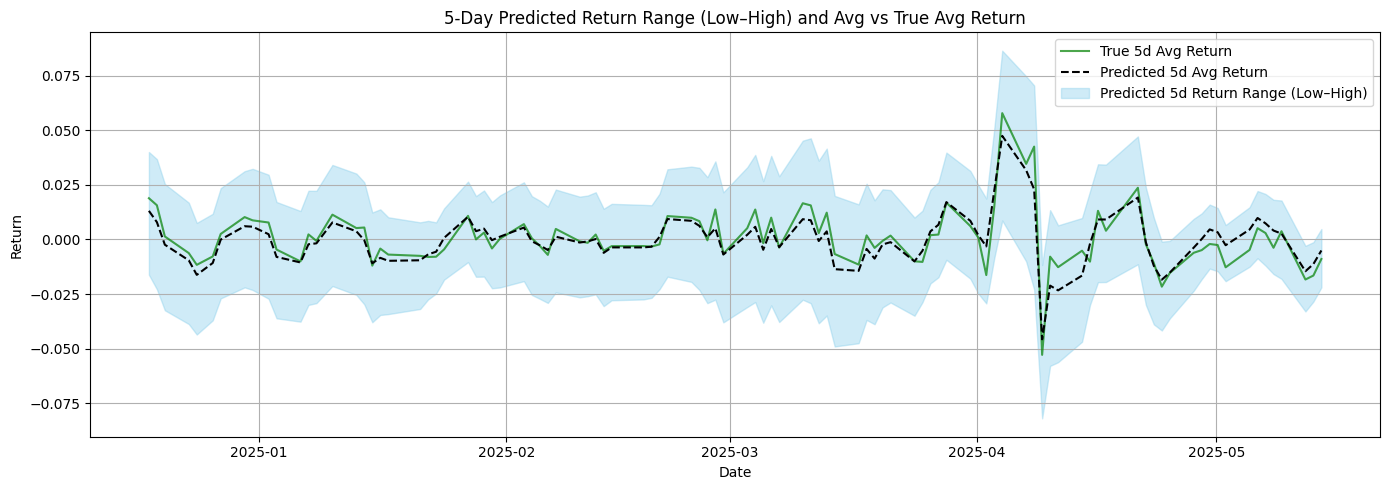

In [2]:
def plot_combined_return_ranges_with_true(y_test, pred_df, n=100):
    idx = pred_df.index[-n:]
    plt.figure(figsize=(14, 5))

    # True 5d average return
    plt.plot(idx, y_test["Avg_5d_return"].loc[idx], label="True 5d Avg Return", color="green", linestyle="-", alpha=0.7)

    # Predicted 5d average return
    plt.plot(idx, pred_df["Avg_5d_return"].loc[idx], label="Predicted 5d Avg Return", color="black", linestyle="--")

    # Predicted min-max return band
    plt.fill_between(
        idx,
        pred_df["Low_5d_return"].loc[idx],
        pred_df["High_5d_return"].loc[idx],
        color="skyblue",
        alpha=0.4,
        label="Predicted 5d Return Range (Low–High)"
    )

    plt.title("5-Day Predicted Return Range (Low–High) and Avg vs True Avg Return")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the updated plot function
plot_combined_return_ranges_with_true(y_test, pred_df)


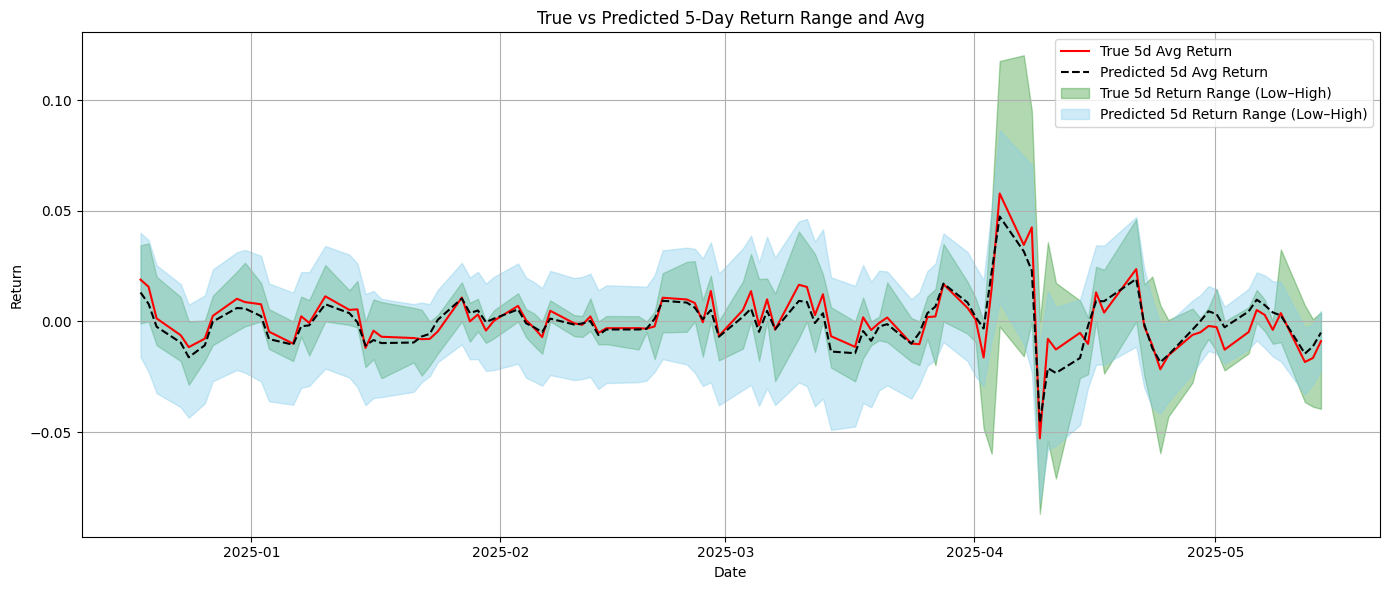

In [3]:
def plot_combined_return_ranges_with_true(y_test, pred_df, n=100):
    idx = pred_df.index[-n:]
    plt.figure(figsize=(14, 6))

    # True 5d average return
    plt.plot(idx, y_test["Avg_5d_return"].loc[idx], label="True 5d Avg Return", color="red", linestyle="-")

    # Predicted 5d average return
    plt.plot(idx, pred_df["Avg_5d_return"].loc[idx], label="Predicted 5d Avg Return", color="black", linestyle="--")

    # True return range shaded area
    plt.fill_between(
        idx,
        y_test["Low_5d_return"].loc[idx],
        y_test["High_5d_return"].loc[idx],
        color="green",
        alpha=0.3,
        label="True 5d Return Range (Low–High)"
    )

    # Predicted return range shaded area
    plt.fill_between(
        idx,
        pred_df["Low_5d_return"].loc[idx],
        pred_df["High_5d_return"].loc[idx],
        color="skyblue",
        alpha=0.4,
        label="Predicted 5d Return Range (Low–High)"
    )

    plt.title("True vs Predicted 5-Day Return Range and Avg")
    plt.xlabel("Date")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Call the final combined plot
plot_combined_return_ranges_with_true(y_test, pred_df)


## ARIMAX Model


📊 ARIMAX - 5-Day Avg Close Prediction
📉 MSE: 436.85
📏 MAE: 13.23
📈 R²: 0.9997


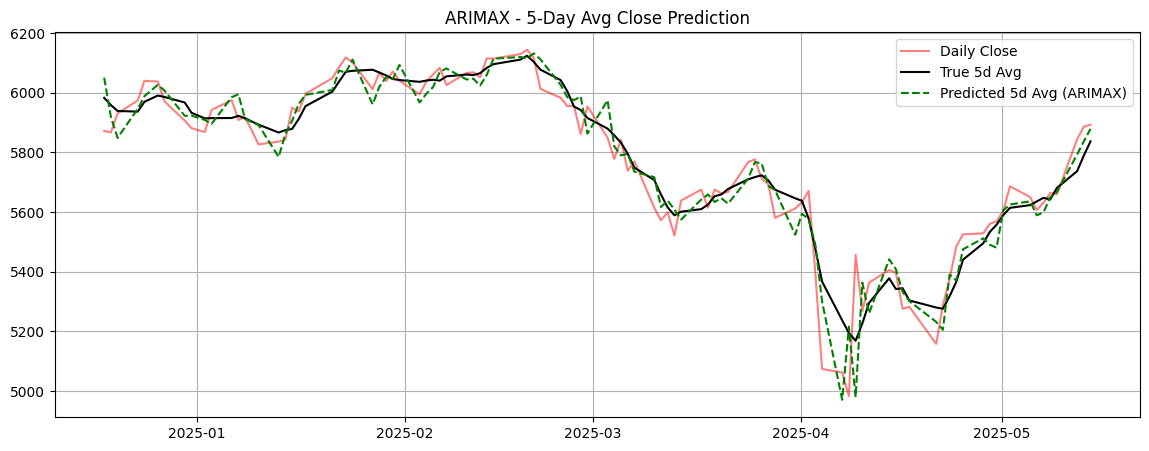

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX     # pip install statsmodels -- install statsmodels for using ARIMAX model 
import warnings
warnings.filterwarnings("ignore")


# 1. Setup Target and Exog Data

# Use same features and target as before
exog = sp500[predictors]
target = sp500["Close_5d_avg"]

# Train-test split
split_index = int(0.6 * len(sp500))
exog_train, exog_test = exog.iloc[:split_index], exog.iloc[split_index:]
y_train, y_test = target.iloc[:split_index], target.iloc[split_index:]


# 2. Fit ARIMAX Model

model = SARIMAX(
    y_train,
    exog=exog_train,
    order=(1, 0, 1),  # AR(1), no differencing, MA(1) — basic to start
    enforce_stationarity=False,
    enforce_invertibility=False
)

model_fit = model.fit(disp=False)


# 3. Forecast

forecast = model_fit.predict(start=split_index, end=len(sp500)-1, exog=exog_test)
forecast.index = y_test.index  # Align forecast with the datetime index of the test set



# 4. Evaluate

mse = mean_squared_error(y_test, forecast)
mae = mean_absolute_error(y_test, forecast)
r2 = r2_score(y_test, forecast)

print("\n📊 ARIMAX - 5-Day Avg Close Prediction")
print(f"📉 MSE: {mse:.2f}")
print(f"📏 MAE: {mae:.2f}")
print(f"📈 R²: {r2:.4f}")


# 5. Plot

plt.figure(figsize=(14, 5))
idx = y_test.index[-100:]
plt.plot(sp500["Close"].loc[idx], label="Daily Close", color="red", alpha=0.5)
plt.plot(y_test.loc[idx], label="True 5d Avg", color="black")
plt.plot(forecast.loc[idx], label="Predicted 5d Avg (ARIMAX)", linestyle="--", color="green")
plt.title("ARIMAX - 5-Day Avg Close Prediction")
plt.legend()
plt.grid(True)
plt.show()



📊 ARIMAX - 5-Day AVG Close
📉 MSE: 436.85
📏 MAE: 13.23
📈 R²: 0.9997

📊 ARIMAX - 5-Day MIN Close
📉 MSE: 1155.14
📏 MAE: 23.43
📈 R²: 0.9993

📊 ARIMAX - 5-Day MAX Close
📉 MSE: 1165.23
📏 MAE: 21.61
📈 R²: 0.9993


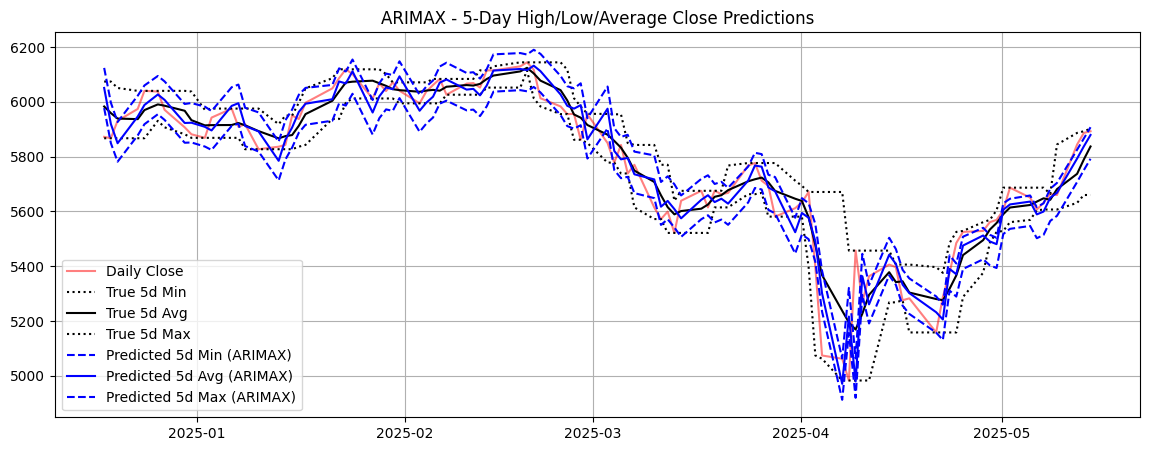

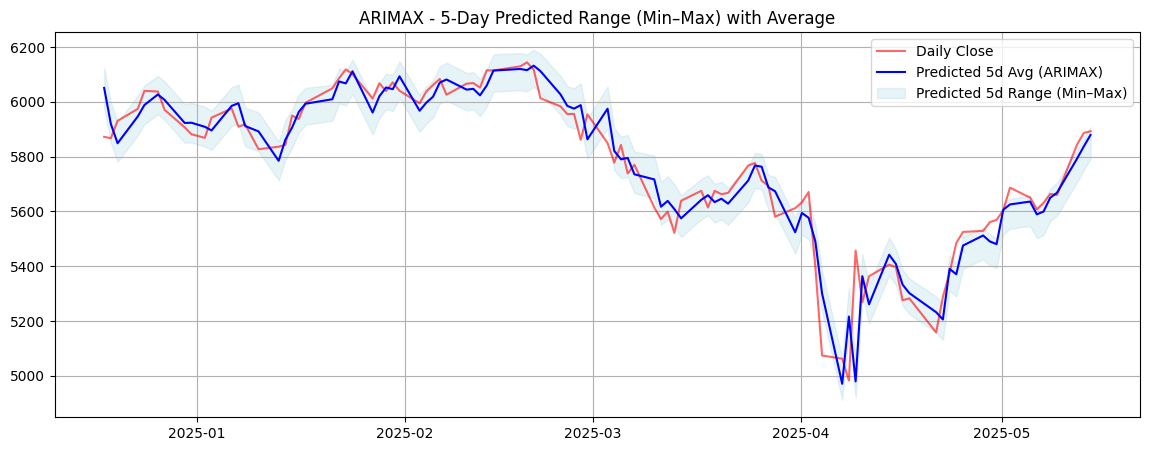

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")


# 1. Setup Features & Targets

exog = sp500[[
    "Open_Price", "RSI", "MACD_diff", "bollinger_pct",
    "Close_Ratio_5", "Trend_5", "Close_Ratio_250", "Trend_250"
]]
targets = {
    "avg": sp500["Close_5d_avg"],
    "min": sp500["Close_5d_min"],
    "max": sp500["Close_5d_max"]
}

# Train-test split
split_index = int(0.6 * len(sp500))
exog_train, exog_test = exog.iloc[:split_index], exog.iloc[split_index:]
forecast_index = exog_test.index  # Shared index for all forecasts

# Container for forecasts
forecasts = {}


# 2. Train ARIMAX for Each Target

for label, series in targets.items():
    y_train = series.iloc[:split_index]
    y_test = series.iloc[split_index:]

    model = SARIMAX(
        y_train,
        exog=exog_train,
        order=(1, 0, 1),
        enforce_stationarity=False,
        enforce_invertibility=False
    )

    model_fit = model.fit(disp=False)
    pred = model_fit.predict(start=split_index, end=len(sp500)-1, exog=exog_test)
    pred.index = forecast_index
    forecasts[label] = pred

    # Evaluate
    mse = mean_squared_error(y_test, pred)
    mae = mean_absolute_error(y_test, pred)
    r2 = r2_score(y_test, pred)
    
    print(f"\n📊 ARIMAX - 5-Day {label.upper()} Close")
    print(f"📉 MSE: {mse:.2f}")
    print(f"📏 MAE: {mae:.2f}")
    print(f"📈 R²: {r2:.4f}")


# 3. Plot All in One Chart

def plot_arimax_range(y_test_dict, forecasts, close, n=100):
    idx = forecasts["avg"].index[-n:]

    plt.figure(figsize=(14, 5))
    plt.plot(close.loc[idx], label="Daily Close", color="red", alpha=0.5)

    # True values
    plt.plot(targets["min"].loc[idx], label="True 5d Min", color="black", linestyle=":")
    plt.plot(targets["avg"].loc[idx], label="True 5d Avg", color="black")
    plt.plot(targets["max"].loc[idx], label="True 5d Max", color="black", linestyle=":")

    # Predictions
    plt.plot(forecasts["min"].loc[idx], label="Predicted 5d Min (ARIMAX)", color="blue", linestyle="--")
    plt.plot(forecasts["avg"].loc[idx], label="Predicted 5d Avg (ARIMAX)", color="blue", linestyle="-")
    plt.plot(forecasts["max"].loc[idx], label="Predicted 5d Max (ARIMAX)", color="blue", linestyle="--")

    plt.title("ARIMAX - 5-Day High/Low/Average Close Predictions")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_arimax_range(targets, forecasts, sp500["Close"])

def plot_arimax_band(forecasts, close, n=100):
    idx = forecasts["avg"].index[-n:]

    plt.figure(figsize=(14, 5))

    # Plot daily close
    plt.plot(close.loc[idx], label="Daily Close", color="red", alpha=0.6)

    # Plot predicted 5-day average
    plt.plot(forecasts["avg"].loc[idx], label="Predicted 5d Avg (ARIMAX)", color="blue")

    # Fill between predicted min and max
    plt.fill_between(
        idx,
        forecasts["min"].loc[idx],
        forecasts["max"].loc[idx],
        color="lightblue",
        alpha=0.3,
        label="Predicted 5d Range (Min–Max)"
    )

    plt.title("ARIMAX - 5-Day Predicted Range (Min–Max) with Average")
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_arimax_band(forecasts, sp500["Close"])




## Testing Transformer

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load and preprocess data
def load_data():
    sp500 = yf.Ticker("^GSPC").history(period="max")
    sp500 = sp500.loc["1990-01-01":].copy()
    sp500.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)
    
    sp500["High_5d"] = sp500["High"].rolling(5).max().shift(-5)
    sp500["Low_5d"] = sp500["Low"].rolling(5).min().shift(-5)

    horizons = [5, 20, 60, 250]
    for h in horizons:
        sp500[f"Close_Ratio_{h}"] = sp500["Close"] / sp500["Close"].rolling(h).mean()
        sp500[f"Trend_{h}"] = sp500["Close"].pct_change().rolling(h).sum()

    sp500["RSI"] = RSIIndicator(close=sp500["Close"]).rsi()
    sp500["Stoch_%K"] = StochasticOscillator(high=sp500["High"], low=sp500["Low"], close=sp500["Close"]).stoch()
    macd = MACD(close=sp500["Close"])
    sp500["MACD"] = macd.macd()
    sp500["MACD_signal"] = macd.macd_signal()
    sp500["EMA_20"] = EMAIndicator(close=sp500["Close"], window=20).ema_indicator()
    sp500["ATR"] = AverageTrueRange(high=sp500["High"], low=sp500["Low"], close=sp500["Close"], window=14).average_true_range()
    boll = BollingerBands(close=sp500["Close"])
    sp500["bollinger_pct"] = (sp500["Close"] - boll.bollinger_lband()) / (boll.bollinger_hband() - boll.bollinger_lband())
    sp500["OBV"] = OnBalanceVolumeIndicator(close=sp500["Close"], volume=sp500["Volume"]).on_balance_volume()
    
    sp500["dayofweek"] = sp500.index.dayofweek / 6.0
    sp500["month"] = (sp500.index.month - 1) / 11.0
    
    sp500.dropna(inplace=True)
    return sp500

sp500 = load_data()

In [5]:
# 2. Train-test split
test_size = 0.4
split_idx = int(len(sp500) * (1 - test_size))
train_data = sp500.iloc[:split_idx]
test_data = sp500.iloc[split_idx:]

# 3. Scaling
features = [
    "RSI", "Stoch_%K", "MACD", "MACD_signal", "EMA_20",
    "ATR", "bollinger_pct", "OBV", "Close_Ratio_5",
    "Trend_5", "Close_Ratio_250", "Trend_250", "dayofweek", "month"
]
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_data[features])
test_scaled = scaler.transform(test_data[features])

# 4. Sequence generation
sequence_length = 30
def create_sequences(data, targets):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(targets.iloc[i+sequence_length].values)
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, train_data[["Low_5d", "High_5d"]])
X_test, y_test = create_sequences(test_scaled, test_data[["Low_5d", "High_5d"]])

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

In [ ]:

# 5. Transformer Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class PriceTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, nhead=8, num_layers=3, dropout=0.1):
        super().__init__()
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.output(x[:, -1])

model = PriceTransformer(input_dim=len(features)).to(device)
loss_fn = nn.HuberLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)


In [9]:
# 6. Training
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=128)

def validate(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)
            total_loss += loss.item()
    return total_loss / len(data_loader)

best_loss = float('inf')
patience = 5
trigger_times = 0

for epoch in range(100):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = validate(model, val_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

Epoch   1 | Train Loss: 969.6003 | Val Loss: 3007.1623
Epoch   2 | Train Loss: 963.6174 | Val Loss: 2998.7625
Epoch   3 | Train Loss: 953.2922 | Val Loss: 2985.4014
Epoch   4 | Train Loss: 935.6882 | Val Loss: 2966.8349
Epoch   5 | Train Loss: 915.3366 | Val Loss: 2943.0027
Epoch   6 | Train Loss: 889.2110 | Val Loss: 2913.6461
Epoch   7 | Train Loss: 855.4306 | Val Loss: 2878.3492
Epoch   8 | Train Loss: 817.3620 | Val Loss: 2836.7293
Epoch   9 | Train Loss: 773.2224 | Val Loss: 2788.3903
Epoch  10 | Train Loss: 720.9661 | Val Loss: 2732.8803
Epoch  11 | Train Loss: 660.1232 | Val Loss: 2669.7883
Epoch  12 | Train Loss: 595.3403 | Val Loss: 2598.7448
Epoch  13 | Train Loss: 532.3494 | Val Loss: 2519.4783
Epoch  14 | Train Loss: 478.4921 | Val Loss: 2434.8778
Epoch  15 | Train Loss: 400.3728 | Val Loss: 2338.2371
Epoch  16 | Train Loss: 326.6062 | Val Loss: 2235.6490
Epoch  17 | Train Loss: 255.8776 | Val Loss: 2124.5041
Epoch  18 | Train Loss: 187.5044 | Val Loss: 2007.5278
Epoch  19 

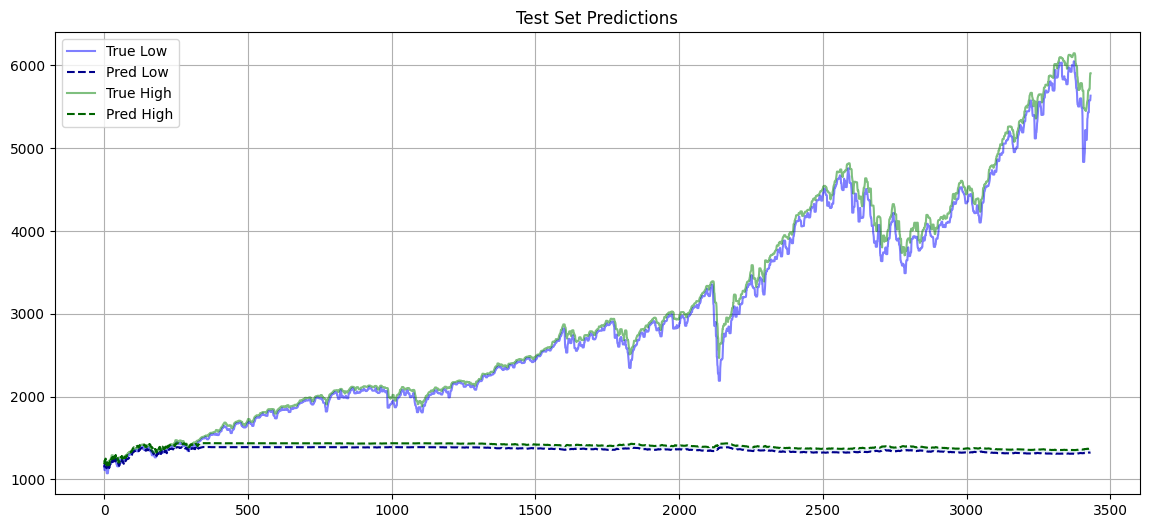

Train Metrics:
Low MAE: 30.60 | High MAE: 25.07

Test Metrics:
Low MAE: 1595.21 | High MAE: 1638.38


In [ ]:

# 7. Evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    train_preds = model(X_train_t).cpu().numpy()
    test_preds = model(X_test_t).cpu().numpy()

def plot_predictions(true, preds, title):
    plt.figure(figsize=(14, 6))
    plt.plot(true[:, 0], label="True Low", color='blue', alpha=0.5)
    plt.plot(preds[:, 0], label="Pred Low", linestyle='--', color='darkblue')
    plt.plot(true[:, 1], label="True High", color='green', alpha=0.5)
    plt.plot(preds[:, 1], label="Pred High", linestyle='--', color='darkgreen')
    plt.fill_between(range(len(true)), preds[:, 0], preds[:, 1], alpha=0.1)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

plot_predictions(y_test_t.cpu().numpy(), test_preds, "Test Set Predictions")

def calculate_metrics(true, pred):
    mae_low = np.mean(np.abs(true[:, 0] - pred[:, 0]))
    mae_high = np.mean(np.abs(true[:, 1] - pred[:, 1]))
    print(f"Low MAE: {mae_low:.2f} | High MAE: {mae_high:.2f}")

print("Train Metrics:")
calculate_metrics(y_train_t.cpu().numpy(), train_preds)
print("\nTest Metrics:")
calculate_metrics(y_test_t.cpu().numpy(), test_preds)


### ROLLING 5 Day average

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
import joblib

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load and preprocess data
def load_data():
    sp500 = yf.Ticker("^GSPC").history(period="max")
    sp500 = sp500.loc["1990-01-01":].copy()
    sp500.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)

    # Future targets: rolling 5-day high and low AFTER the sequence
    sp500["High_5d"] = sp500["High"].shift(-1).rolling(5).max().shift(-4)
    sp500["Low_5d"] = sp500["Low"].shift(-1).rolling(5).min().shift(-4)

    horizons = [5, 20, 60, 250]
    for h in horizons:
        sp500[f"Close_Ratio_{h}"] = sp500["Close"] / sp500["Close"].rolling(h).mean()
        sp500[f"Trend_{h}"] = sp500["Close"].pct_change().rolling(h).sum()

    sp500["RSI"] = RSIIndicator(close=sp500["Close"]).rsi()
    sp500["Stoch_%K"] = StochasticOscillator(high=sp500["High"], low=sp500["Low"], close=sp500["Close"]).stoch()
    macd = MACD(close=sp500["Close"])
    sp500["MACD"] = macd.macd()
    sp500["MACD_signal"] = macd.macd_signal()
    sp500["EMA_20"] = EMAIndicator(close=sp500["Close"], window=20).ema_indicator()
    sp500["ATR"] = AverageTrueRange(high=sp500["High"], low=sp500["Low"], close=sp500["Close"], window=14).average_true_range()
    boll = BollingerBands(close=sp500["Close"])
    sp500["bollinger_pct"] = (sp500["Close"] - boll.bollinger_lband()) / (boll.bollinger_hband() - boll.bollinger_lband())
    sp500["OBV"] = OnBalanceVolumeIndicator(close=sp500["Close"], volume=sp500["Volume"]).on_balance_volume()
    
    sp500["dayofweek"] = sp500.index.dayofweek / 6.0
    sp500["month"] = (sp500.index.month - 1) / 11.0
    
    sp500.dropna(inplace=True)
    return sp500

sp500 = load_data()


In [ ]:

# 2. Train-test split
test_size = 0.2
split_idx = int(len(sp500) * (1 - test_size))
train_data = sp500.iloc[:split_idx]
test_data = sp500.iloc[split_idx:]

# 3. Feature and target scaling
features = [
    "RSI", "Stoch_%K", "MACD", "MACD_signal", "EMA_20",
    "ATR", "bollinger_pct", "OBV", "Close_Ratio_5",
    "Trend_5", "Close_Ratio_250", "Trend_250", "dayofweek", "month"
]
scaler_X = StandardScaler()
train_scaled = scaler_X.fit_transform(train_data[features])
test_scaled = scaler_X.transform(test_data[features])

scaler_y = StandardScaler()
y_train = train_data[["Low_5d", "High_5d"]]
y_test = test_data[["Low_5d", "High_5d"]]
y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

In [ ]:

# 4. Sequence generation
sequence_length = 30
def create_sequences(data, targets):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(targets[i+sequence_length])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_scaled, y_train_scaled)
X_test, y_test = create_sequences(test_scaled, y_test_scaled)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.float32).to(device)

# 5. Transformer Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class PriceTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, nhead=4, num_layers=2, dropout=0.2):
        super().__init__()
        self.pos_encoder = PositionalEncoding(hidden_dim)
        self.embedding = nn.Linear(input_dim, hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.output(x[:, -1])

Using device: cuda
Epoch   1 | Train Loss: 0.2169 | Val Loss: 12.5715
Epoch   2 | Train Loss: 0.0406 | Val Loss: 9.7573
Epoch   3 | Train Loss: 0.0304 | Val Loss: 9.5983
Epoch   4 | Train Loss: 0.0279 | Val Loss: 9.5587
Epoch   5 | Train Loss: 0.0251 | Val Loss: 9.3031
Epoch   6 | Train Loss: 0.0251 | Val Loss: 9.6870
Epoch   7 | Train Loss: 0.0221 | Val Loss: 9.9226
Epoch   8 | Train Loss: 0.0208 | Val Loss: 10.0921
Epoch   9 | Train Loss: 0.0219 | Val Loss: 10.1429
Epoch  10 | Train Loss: 0.0197 | Val Loss: 9.9792
Early stopping!


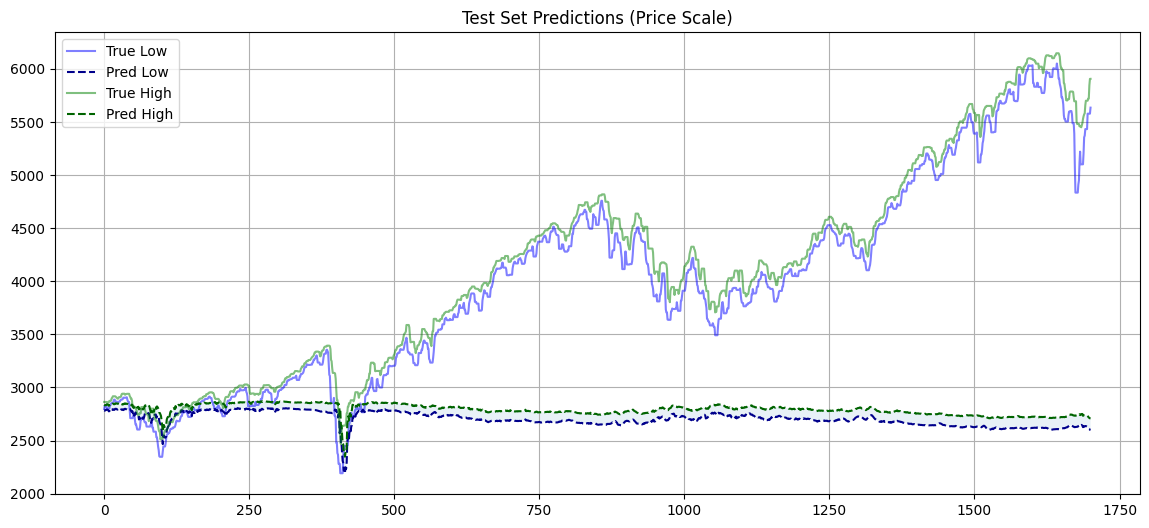

Test MAE - Low: 1288.54, High: 1327.47


In [ ]:

model = PriceTransformer(input_dim=len(features)).to(device)
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.01)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)

# 6. Training
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=128, shuffle=False)

def validate(model, data_loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            preds = model(X)
            loss = loss_fn(preds, y)
            total_loss += loss.item()
    return total_loss / len(data_loader)

best_loss = float('inf')
patience = 5
trigger_times = 0

for epoch in range(100):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        preds = model(X_batch)
        loss = loss_fn(preds, y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    
    val_loss = validate(model, val_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss/len(train_loader):.4f} | Val Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        trigger_times = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        trigger_times += 1
        if trigger_times >= patience:
            print("Early stopping!")
            break

# 7. Evaluation
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
with torch.no_grad():
    test_preds_scaled = model(X_test_t).cpu().numpy()
    test_preds = scaler_y.inverse_transform(test_preds_scaled)
    true_vals = scaler_y.inverse_transform(y_test_t.cpu().numpy())

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(true_vals[:, 0], label="True Low", color='blue', alpha=0.5)
plt.plot(test_preds[:, 0], label="Pred Low", linestyle='--', color='darkblue')
plt.plot(true_vals[:, 1], label="True High", color='green', alpha=0.5)
plt.plot(test_preds[:, 1], label="Pred High", linestyle='--', color='darkgreen')
plt.fill_between(range(len(true_vals)), test_preds[:, 0], test_preds[:, 1], alpha=0.1)
plt.title("Test Set Predictions (Price Scale)")
plt.legend()
plt.grid(True)
plt.show()

# Final metrics
mae_low = np.mean(np.abs(true_vals[:, 0] - test_preds[:, 0]))
mae_high = np.mean(np.abs(true_vals[:, 1] - test_preds[:, 1]))
print(f"Test MAE - Low: {mae_low:.2f}, High: {mae_high:.2f}")


### 5 Day Return instead of Rolling average

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from ta.momentum import RSIIndicator, StochasticOscillator
from ta.trend import MACD, EMAIndicator
from ta.volatility import BollingerBands, AverageTrueRange
from ta.volume import OnBalanceVolumeIndicator
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# 1. Load and preprocess data
def load_data():
    sp500 = yf.Ticker("^GSPC").history(period="max")
    sp500 = sp500.loc["1990-01-01":].copy()
    sp500.drop(["Dividends", "Stock Splits"], axis=1, inplace=True)
    
    # Targets in return space
    sp500["High_5d_return"] = (sp500["High"].rolling(5).max().shift(-5) / sp500["Close"]) - 1
    sp500["Low_5d_return"] = (sp500["Low"].rolling(5).min().shift(-5) / sp500["Close"]) - 1

    # Feature Engineering
    horizons = [5, 20, 60, 250]
    for h in horizons:
        sp500[f"Close_Ratio_{h}"] = sp500["Close"] / sp500["Close"].rolling(h).mean()
        sp500[f"Trend_{h}"] = sp500["Close"].pct_change().rolling(h).sum()

    sp500["RSI"] = RSIIndicator(close=sp500["Close"]).rsi()
    sp500["Stoch_%K"] = StochasticOscillator(high=sp500["High"], low=sp500["Low"], close=sp500["Close"]).stoch()
    macd = MACD(close=sp500["Close"])
    sp500["MACD"] = macd.macd()
    sp500["MACD_signal"] = macd.macd_signal()
    sp500["EMA_20"] = EMAIndicator(close=sp500["Close"], window=20).ema_indicator()
    sp500["ATR"] = AverageTrueRange(high=sp500["High"], low=sp500["Low"], close=sp500["Close"]).average_true_range()
    boll = BollingerBands(close=sp500["Close"])
    sp500["bollinger_pct"] = (sp500["Close"] - boll.bollinger_lband()) / (boll.bollinger_hband() - boll.bollinger_lband())
    sp500["OBV"] = OnBalanceVolumeIndicator(close=sp500["Close"], volume=sp500["Volume"]).on_balance_volume()
    sp500["dayofweek"] = sp500.index.dayofweek / 6.0
    sp500["month"] = (sp500.index.month - 1) / 11.0
    sp500["Open_Price"] = sp500["Open"]
    sp500["Prev_Close"] = sp500["Close"].shift(1)
    sp500.dropna(inplace=True)
    return sp500

sp500 = load_data()

In [ ]:

features = [
    "Prev_Close",
    "Open_Price",                #  Known at market open
    "RSI", "MACD",          #  Technical indicators from past close prices
    "bollinger_pct",             #  Calculated before market open
    "Close_Ratio_5", "Trend_5",  #  Short-term price context
    "Close_Ratio_250", "Trend_250",  #  Long-term context
    "dayofweek", "month"         #  Optional seasonality patterns
]

targets = ["Low_5d_return", "High_5d_return"]

X = sp500[features]
y = sp500[targets]

# 3. Scaling
X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_scaled = X_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [4]:
# 4. Sequence generation
sequence_length = 30
def create_sequences(data, targets):
    X_seq, y_seq = [], []
    for i in range(len(data) - sequence_length):
        X_seq.append(data[i:i+sequence_length])
        y_seq.append(targets[i+sequence_length])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)
X_t = torch.tensor(X_seq, dtype=torch.float32)
y_t = torch.tensor(y_seq, dtype=torch.float32)

# 5. Train-test split
split = int(0.8 * len(X_t))
X_train, X_test = X_t[:split], X_t[split:]
y_train, y_test = y_t[:split], y_t[split:]


In [21]:
# 6. Transformer Model
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))
    
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class PriceTransformer(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, nhead=8, num_layers=4, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, hidden_dim)
        self.pos_encoder = PositionalEncoding(hidden_dim)
        encoder_layer = nn.TransformerEncoderLayer(d_model=hidden_dim, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        x = self.transformer(x)
        return self.output(x[:, -1])

model = PriceTransformer(input_dim=len(features), hidden_dim=256, nhead=4, num_layers=4).cuda()

#loss_fn = nn.HuberLoss()
loss_fn = nn.MSELoss()  # More sensitive to low variance targets
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10)

In [22]:

# 7. Training
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=128)

best_loss = float("inf")
patience = 10
trigger = 0

for epoch in range(100):
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.cuda(), yb.cuda()
        optimizer.zero_grad()
        pred = model(xb)
        loss = loss_fn(pred, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item()
    val_loss = 0
    model.eval()
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.cuda(), yb.cuda()
            pred = model(xb)
            val_loss += loss_fn(pred, yb).item()
    val_loss /= len(val_loader)
    train_loss /= len(train_loader)
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1:3d} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    if val_loss < best_loss:
        best_loss = val_loss
        trigger = 0
        torch.save(model.state_dict(), "best_return_model.pth")
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping!")
            break


Epoch   1 | Train Loss: 0.8108 | Val Loss: 1.1635
Epoch   2 | Train Loss: 0.7473 | Val Loss: 1.1627
Epoch   3 | Train Loss: 0.7289 | Val Loss: 1.1366
Epoch   4 | Train Loss: 0.7127 | Val Loss: 1.1490
Epoch   5 | Train Loss: 0.6831 | Val Loss: 1.2556
Epoch   6 | Train Loss: 0.6754 | Val Loss: 1.2388
Epoch   7 | Train Loss: 0.6453 | Val Loss: 1.2835
Epoch   8 | Train Loss: 0.6103 | Val Loss: 1.3094
Epoch   9 | Train Loss: 0.5779 | Val Loss: 1.4877
Epoch  10 | Train Loss: 0.5480 | Val Loss: 1.4865
Epoch  11 | Train Loss: 0.5156 | Val Loss: 1.4743
Epoch  12 | Train Loss: 0.5050 | Val Loss: 1.4343
Epoch  13 | Train Loss: 0.4607 | Val Loss: 1.4303
Early stopping!


In [23]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load best model
model.load_state_dict(torch.load("best_return_model.pth"))
model.eval()

# Predict on test set
with torch.no_grad():
    preds_scaled = model(X_test.cuda()).cpu().numpy()
    y_true_scaled = y_test.cpu().numpy()

# Inverse transform to return space
preds = y_scaler.inverse_transform(preds_scaled)
y_true = y_scaler.inverse_transform(y_true_scaled)

# Evaluation Metrics
mae_low = mean_absolute_error(y_true[:, 0], preds[:, 0])
mae_high = mean_absolute_error(y_true[:, 1], preds[:, 1])
rmse_low = mean_squared_error(y_true[:, 0], preds[:, 0])
rmse_high = mean_squared_error(y_true[:, 1], preds[:, 1])

print(f"\nEvaluation (in return space):")
print(f"MAE - Low 5D Return:  {mae_low:.4f}")
print(f"MAE - High 5D Return: {mae_high:.4f}")
print(f"RMSE - Low 5D Return:  {rmse_low:.4f}")
print(f"RMSE - High 5D Return: {rmse_high:.4f}")



Evaluation (in return space):
MAE - Low 5D Return:  0.0143
MAE - High 5D Return: 0.0101
RMSE - Low 5D Return:  0.0005
RMSE - High 5D Return: 0.0002


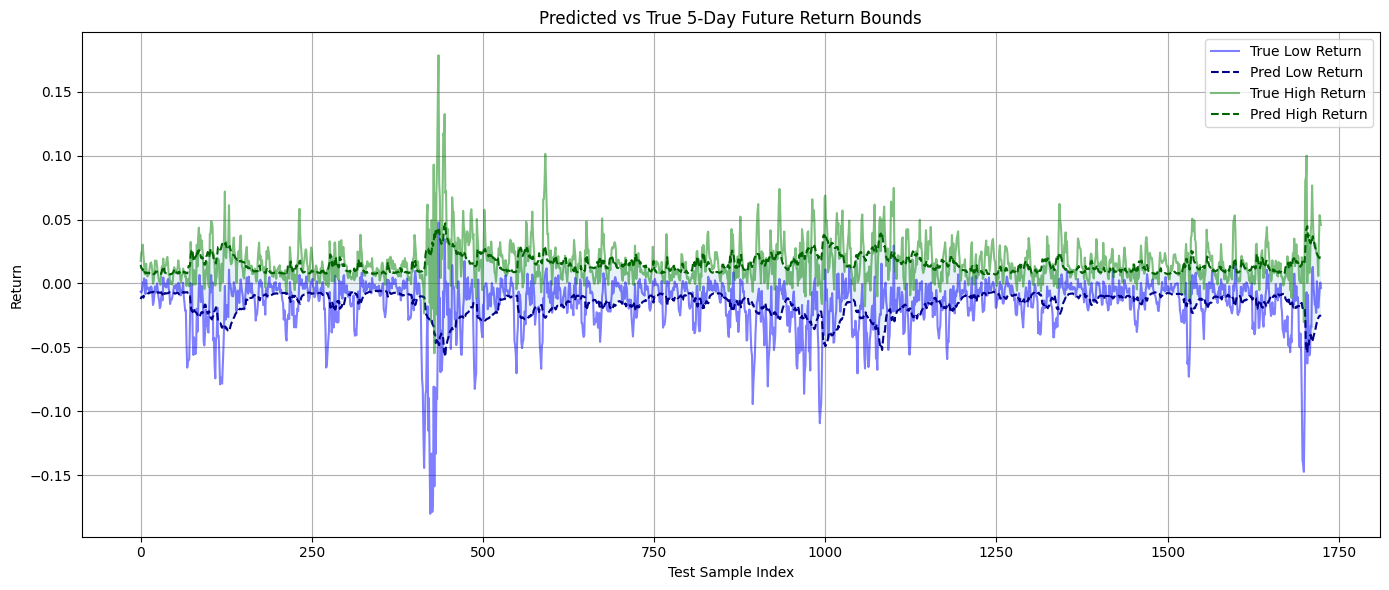

In [24]:
plt.figure(figsize=(14, 6))

# Plot Low Returns
plt.plot(y_true[:, 0], label="True Low Return", color='blue', alpha=0.5)
plt.plot(preds[:, 0], label="Pred Low Return", linestyle='--', color='darkblue')

# Plot High Returns
plt.plot(y_true[:, 1], label="True High Return", color='green', alpha=0.5)
plt.plot(preds[:, 1], label="Pred High Return", linestyle='--', color='darkgreen')

# Optional: Add fill between
plt.fill_between(range(len(preds)), preds[:, 0], preds[:, 1], alpha=0.1)

plt.title("Predicted vs True 5-Day Future Return Bounds")
plt.xlabel("Test Sample Index")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


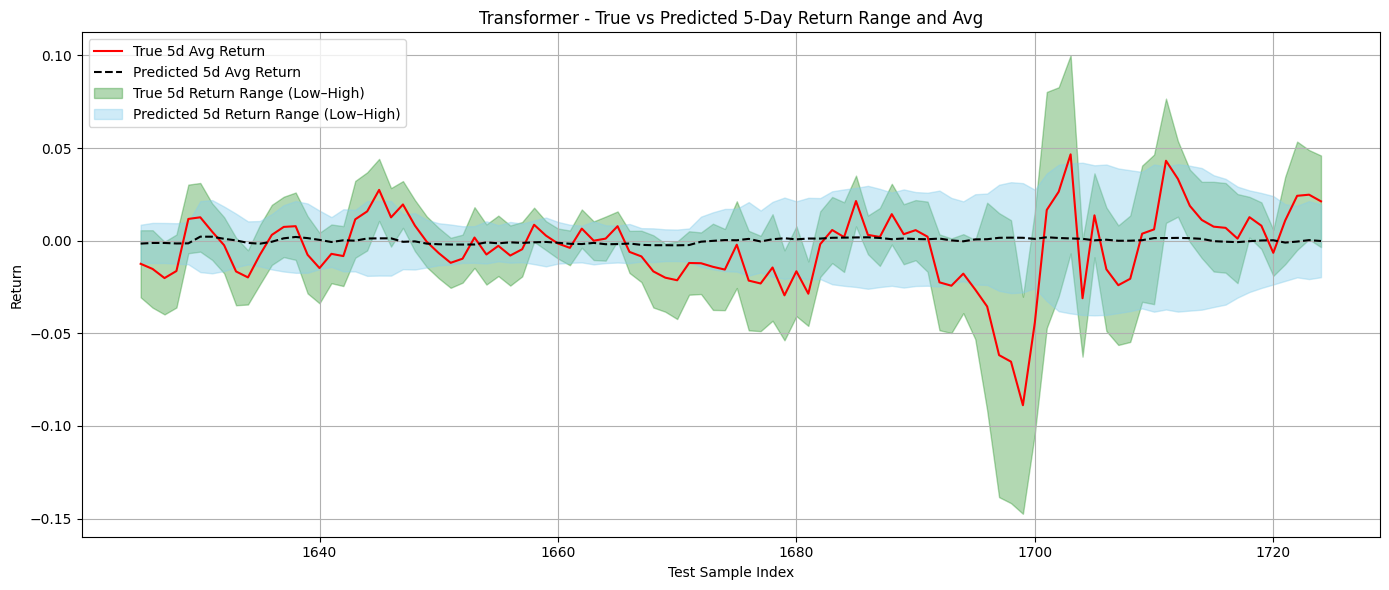

In [28]:
# Create prediction and true DataFrames
pred_df = pd.DataFrame(preds, columns=["Low_5d_return", "High_5d_return"])
pred_df["Avg_5d_return"] = (pred_df["Low_5d_return"] + pred_df["High_5d_return"]) / 2

true_df = pd.DataFrame(y_true, columns=["Low_5d_return", "High_5d_return"])
true_df["Avg_5d_return"] = (true_df["Low_5d_return"] + true_df["High_5d_return"]) / 2

# Plot like linear regression version
def plot_combined_return_ranges_with_true(y_test_df, pred_df, n=100):
    idx = pred_df.index[-n:]
    plt.figure(figsize=(14, 6))

    # True average
    plt.plot(idx, y_test_df["Avg_5d_return"].iloc[-n:], label="True 5d Avg Return", color="red", linestyle="-")

    # Predicted average
    plt.plot(idx, pred_df["Avg_5d_return"].iloc[-n:], label="Predicted 5d Avg Return", color="black", linestyle="--")

    # Shaded true range
    plt.fill_between(
        idx,
        y_test_df["Low_5d_return"].iloc[-n:],
        y_test_df["High_5d_return"].iloc[-n:],
        color="green", alpha=0.3,
        label="True 5d Return Range (Low–High)"
    )

    # Shaded predicted range
    plt.fill_between(
        idx,
        pred_df["Low_5d_return"].iloc[-n:],
        pred_df["High_5d_return"].iloc[-n:],
        color="skyblue", alpha=0.4,
        label="Predicted 5d Return Range (Low–High)"
    )

    plt.title("Transformer - True vs Predicted 5-Day Return Range and Avg")
    plt.xlabel("Test Sample Index")
    plt.ylabel("Return")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Run it
plot_combined_return_ranges_with_true(true_df, pred_df)


### Testing Facebook Prophet for stock price forecasting

[*********************100%***********************]  1 of 1 completed

✅ Data Loaded:
 Price        Date       Close        High         Low        Open    Volume
Ticker                   AAPL        AAPL        AAPL        AAPL      AAPL
6376   2025-05-09  198.270004  200.277366  197.281295  198.739390  36453900
6377   2025-05-12  210.789993  211.270004  206.750000  210.970001  63775800
6378   2025-05-13  212.929993  213.399994  209.000000  210.429993  51909300
6379   2025-05-14  212.330002  213.940002  210.580002  212.429993  49325800
6380   2025-05-15  211.449997  212.960007  209.539993  210.949997  44979900
📋 Flattened columns: Index(['Date', 'CloseAAPL', 'HighAAPL', 'LowAAPL', 'OpenAAPL', 'VolumeAAPL'], dtype='object')
           Date   CloseAAPL    HighAAPL     LowAAPL    OpenAAPL  VolumeAAPL
0    2000-01-03    0.841048    0.845274    0.764034    0.787983   535796800
1    2000-01-04    0.770139    0.831186    0.760277    0.813342   512377600
2    2000-01-05    0.781408    0.830716    0.773895    0.779530   778321600
3    2000-01-06    0.713786    0.

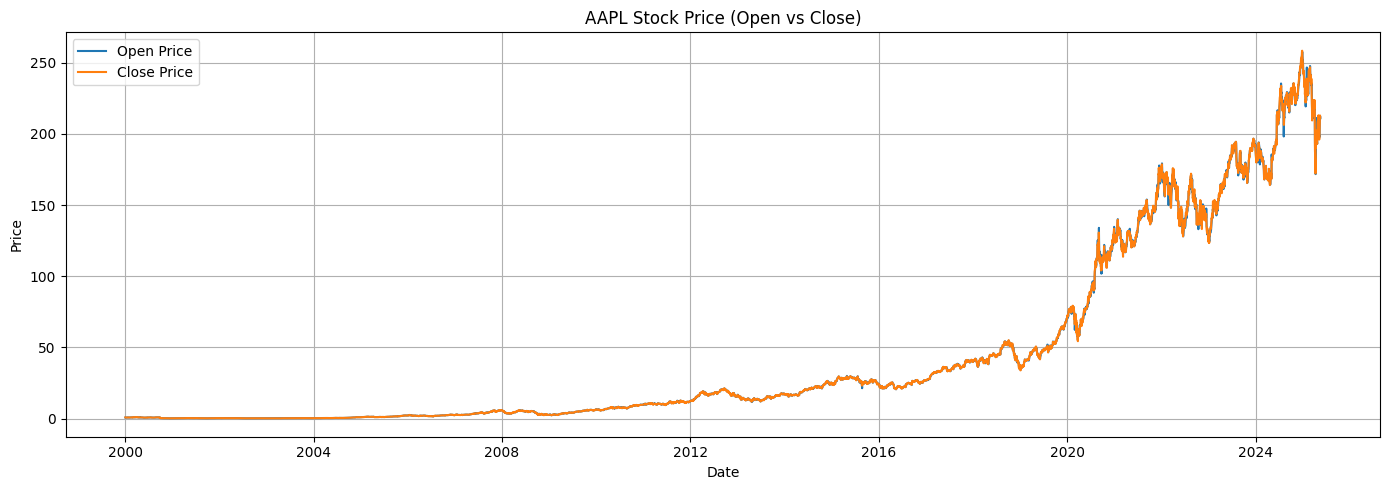

In [ ]:
from datetime import date
import pandas as pd
import yfinance as yf
from prophet import Prophet             # pip install prophet -- Install facebook prophet to run
from prophet.plot import plot_plotly
import matplotlib.pyplot as plt


# 1. Configuration

START = "2000-01-01"
TODAY = date.today().strftime("%Y-%m-%d")
selected_stock = "AAPL"  # Change to "GOOG", "MSFT", "GME" etc.
n_years = 2
period = n_years * 365


# 2. Load Data

print(f"Downloading data for {selected_stock}...")
df = yf.download(selected_stock, START, TODAY)

if df.empty:
    raise ValueError("No data fetched. Please check the ticker symbol.")
df.reset_index(inplace=True)
print(" Data Loaded:\n", df.tail())
# Flatten MultiIndex columns (Price, Ticker) to single strings like 'Close_AAPL'
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [''.join(col).strip() for col in df.columns.values]
print("📋 Flattened columns:", df.columns)


print(df)
# Additional indicators

# 3. Plot Raw Data

plt.figure(figsize=(14, 5))
plt.plot(df["Date"], df["OpenAAPL"], label="Open Price")
plt.plot(df["Date"], df["CloseAAPL"], label="Close Price")
plt.title(f"{selected_stock} Stock Price (Open vs Close)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


📈 Training Prophet model...


20:52:09 - cmdstanpy - INFO - Chain [1] start processing
20:52:12 - cmdstanpy - INFO - Chain [1] done processing


✅ Forecast completed.
              ds        yhat  yhat_lower  yhat_upper
7106 2027-05-11  279.061126  264.630673  294.139787
7107 2027-05-12  279.135185  265.450373  293.885440
7108 2027-05-13  279.186423  264.125696  294.512660
7109 2027-05-14  279.275008  265.284727  293.531435
7110 2027-05-15  279.439721  264.918329  293.884226


🔍 Forecast components (trend, seasonality):


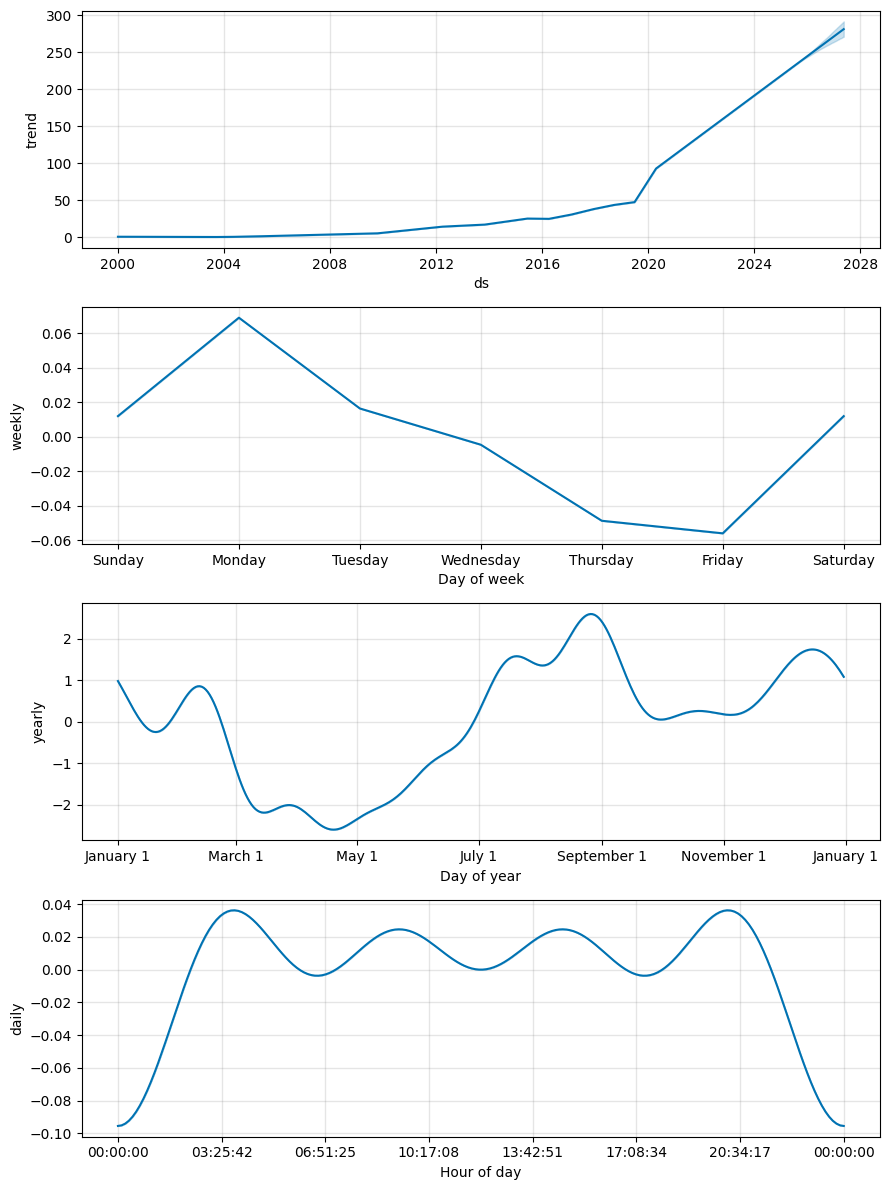

In [ ]:

# 4. Prepare for Prophet

# Dynamically find the correct 'Close' column (e.g., CloseAAPL)
close_col = [col for col in df.columns if 'Close' in col][0]

df_train = df[['Date', close_col]].copy()
df_train.rename(columns={'Date': 'ds', close_col: 'y'}, inplace=True)
df_train['y'] = pd.to_numeric(df_train['y'], errors='coerce')
df_train.dropna(subset=['y', 'ds'], inplace=True)


# 5. Prophet Forecasting

print(" Training Prophet model...")
m = Prophet(daily_seasonality=True)
m.fit(df_train)

future = m.make_future_dataframe(periods=period)
forecast = m.predict(future)

# Show forecast sample
print(" Forecast completed.\n", forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# 6. Plot Forecast (Interactive)

fig1 = plot_plotly(m, forecast)
fig1.update_layout(title=f"{selected_stock} Forecast for {n_years} Years")
fig1.show()


# 7. Plot Forecast Components

print(" Forecast components (trend, seasonality):")
m.plot_components(forecast)
plt.tight_layout()
plt.show()


After benchmarking all models and considering interpretability, speed, and generalization, we can concludes that a multi-output linear regression model is the best fit for the trading bot due to its simplicity, transparency, and strong real-world performance in out-of-sample testing.